# Problem statement

In order to improve user retention and lowern churn, the growth team at Robinhood is interested in understanding why and which users withdraw money from their Robinhood account. A user is considered churned when their equity value(amount of money in Robinhood account) falls below 10 dollars for a period of 28 consecutive calendar days or longer after having previously been atleast $10.


#### Steps involved

1. Data Understanding and EDA
2. Data Preparation for Model building
3. Model Building and Evaluation
4. Summary [Answers to the questions]

## 1. Data Understanding and EDA

In [1]:
!pip install graphviz

In [2]:
# Import the required libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import pytz
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, auc
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE


from sklearn import tree
import graphviz
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier


# Suppress warnings from matplotlib
warnings.filterwarnings("ignore")

In [3]:
features_df = pd.read_csv('features_data.csv')
equity_df = pd.read_csv('equity_value_data.csv')

In [4]:
# Inspecting first 5 rows in the features dataframe
features_df.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91


In [5]:
features_df.shape

(5584, 9)

There are 5584 rows and 9 columns in the features dataframe.

In [6]:
# Checking the type of the attributes
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   risk_tolerance                5584 non-null   object 
 1   investment_experience         5584 non-null   object 
 2   liquidity_needs               5584 non-null   object 
 3   platform                      5584 non-null   object 
 4   time_spent                    5584 non-null   float64
 5   instrument_type_first_traded  5584 non-null   object 
 6   first_deposit_amount          5584 non-null   float64
 7   time_horizon                  5584 non-null   object 
 8   user_id                       5584 non-null   object 
dtypes: float64(2), object(7)
memory usage: 392.8+ KB


There are no null values in the features dataframe.
time_spent and first_deposit_amount are float features and the remaining features are of object type.

In [7]:
duplicate_rows = len(features_df[features_df.duplicated()])
print('Number of duplicate rows in features_df: {}'.format(duplicate_rows))

Number of duplicate rows in features_df: 0


In [8]:
equity_df.head()

,timestamp,close_equity,user_id
0,2016-11-16T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
1,2016-11-17T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
2,2016-11-18T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
3,2016-11-21T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
4,2016-11-22T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03


In [9]:
equity_df.shape

(1119158, 3)

There are 1119158 rows and 3 columns in the equity dataframe.

In [10]:
equity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119158 entries, 0 to 1119157
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   timestamp     1119158 non-null  object 
 1   close_equity  1119158 non-null  float64
 2   user_id       1119158 non-null  object 
dtypes: float64(1), object(2)
memory usage: 25.6+ MB


There are no null values observed in the equity dataframe. close_equity is the only float feature. timestamp and user_id are of object type.

In [11]:
duplicate_rows = len(equity_df[equity_df.duplicated()])
print('Number of duplicate rows in equity_df: {}'.format(duplicate_rows))

Number of duplicate rows in equity_df: 0


## 1.1 Univariate Analysis

Finding the descriptive summary statistics of the features dataframe

In [12]:
features_df.describe()

,time_spent,first_deposit_amount
count,5584.000000,5584.000000
mean,34.509706,633.566805
std,155.080551,2118.323263
min,0.000000,0.000000
25%,2.848908,50.000000
50%,13.474708,100.000000
75%,33.823829,500.000000
max,8788.329450,50000.000000


From the above statistics, 

The distribution of time_spent is skewed to the right. We can see that the mean of time_spent is 34.51 and median is 13.47. Mean value is pulled to its right because of the skewed distribution.

IQR of time_spent defines the spread of data. 
IQR = Q3 - Q1 = 33.823829 - 2.848908 = 30.974921

The distribution of first_deposit_amount is skewed to the right. We can see that the mean of first_deposit_amount is 633.57 and median is 100. Mean value is pulled to its right because of the skewed distribution.

IQR of first_deposit_amount defines the spread of this feature data. 
IQR = Q3 - Q1 = 500 - 50 = 450


<AxesSubplot:>

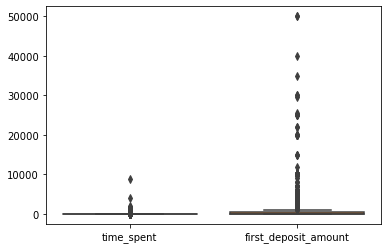

In [13]:
sns.boxplot(data=features_df)

<AxesSubplot:>

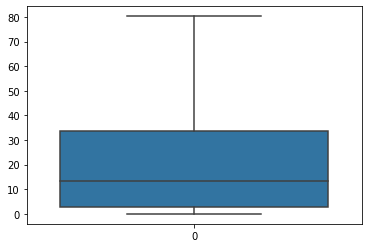

In [14]:
sns.boxplot(data=features_df['time_spent'], 
            showfliers=False)

<AxesSubplot:>

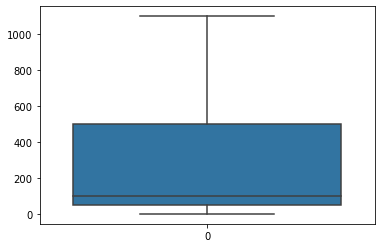

In [15]:
sns.boxplot(data=features_df['first_deposit_amount'], 
            showfliers=False)

In [16]:
equity_df.describe()

,close_equity
count,1.119158e+06
mean,3.976953e+03
std,1.308590e+04
min,1.000000e+01
25%,1.115400e+02
50%,5.787400e+02
75%,2.564560e+03
max,4.789484e+05


Above descriptive summary of close_equity is in scientific notation.

In [17]:
# Applying lambda function for converting values to floating point values with 2 decimal places 
# instead of scientific notation.
equity_df['close_equity'].describe().apply(lambda x: '{0:.2f}'.format(x))

count    1119158.00
mean        3976.95
std        13085.90
min           10.00
25%          111.54
50%          578.74
75%         2564.56
max       478948.41
Name: close_equity, dtype: object

From the above statistics, 

The distribution of close_equity is skewed to the right. We can see that the mean of close_equity is 3976.95 and median is 578.74. Mean value is pulled to its right because of the skewed distribution.

IQR of close_equity defines the spread of this feature data. 
IQR = Q3 - Q1 = 2564.56 - 111.54 = 2453.02

<AxesSubplot:>

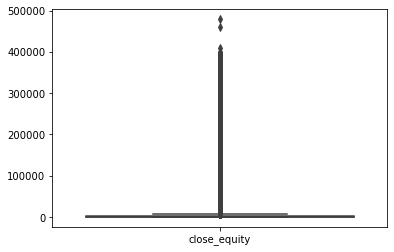

In [18]:
sns.boxplot(data=equity_df)

<AxesSubplot:>

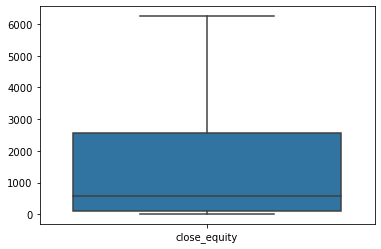

In [19]:
sns.boxplot(data=equity_df, 
            showfliers=False)

In [20]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   risk_tolerance                5584 non-null   object 
 1   investment_experience         5584 non-null   object 
 2   liquidity_needs               5584 non-null   object 
 3   platform                      5584 non-null   object 
 4   time_spent                    5584 non-null   float64
 5   instrument_type_first_traded  5584 non-null   object 
 6   first_deposit_amount          5584 non-null   float64
 7   time_horizon                  5584 non-null   object 
 8   user_id                       5584 non-null   object 
dtypes: float64(2), object(7)
memory usage: 392.8+ KB


In [21]:
# Percentage distribution of risk_tolerance
risk_tol_distribution = features_df['risk_tolerance'].value_counts(normalize=True)
risk_tol_distribution

high_risk_tolerance    0.638610
med_risk_tolerance     0.318589
low_risk_tolerance     0.042801
Name: risk_tolerance, dtype: float64

Most of the users(around 64%) reported that they had high risk tolerance.<br>
Around 32% of the users reported that they had medium risk tolerance.<br>
Remaining 4% reported that they had low risk tolerance.

<AxesSubplot:title={'center':'Frequency distribution of risk tolerance'}, xlabel='risk_tolerance', ylabel='count'>

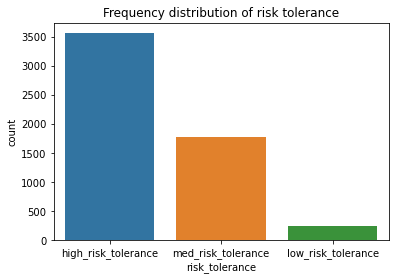

In [22]:
plt.figure(figsize=(6,4))
plt.title('Frequency distribution of risk tolerance')
sns.countplot(data=features_df, 
              x='risk_tolerance')

([<matplotlib.patches.Wedge at 0x22753129430>,
 [Text(-0.4640073872366141, 0.9973450479096244, 'high_risk_tolerance'),
  Text(0.32611684271249897, -1.0505464315770299, 'med_risk_tolerance'),
  Text(1.090070816054314, -0.1474639480913288, 'low_risk_tolerance')],
 [Text(-0.2530949384926986, 0.5440063897688859, '64%'),
  Text(0.17788191420681762, -0.5730253263147436, '32%'),
  Text(0.5945840814841712, -0.08043488077708842, '4%')])

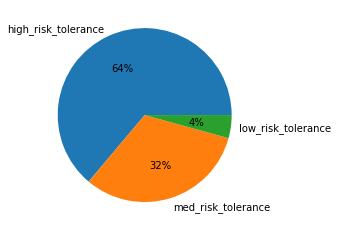

In [23]:
plt.pie(risk_tol_distribution, 
        labels=risk_tol_distribution.index, 
        autopct='%.0f%%')

In [24]:
# Percentage distribution of risk_tolerance
inv_exp_dist = features_df['investment_experience'].value_counts(normalize=True)
inv_exp_dist

limited_investment_exp      0.461676
no_investment_exp           0.321633
good_investment_exp         0.203080
extensive_investment_exp    0.013610
Name: investment_experience, dtype: float64

Around 46% of the users had limited investment experience.<br>
Around 32% of the users had no experience.<br>
Around 20% of the users had good investment experience.<br>
Around 1% of the users had extensive experience.<br>

([<matplotlib.patches.Wedge at 0x22753bc9430>,
 [Text(0.1321177815585536, 1.0920370377400423, 'limited_investment_exp'),
  Text(-0.7899733893419972, -0.7654685128282662, 'no_investment_exp'),
  Text(0.8244342469850349, -0.728222611842161, 'good_investment_exp'),
  Text(1.098994613591798, -0.047019562909652465, 'extensive_investment_exp')],
 [Text(0.07206424448648377, 0.595656566040023, '46%'),
  Text(-0.4308945760047257, -0.4175282797245088, '32%'),
  Text(0.4496914074463826, -0.3972123337320878, '20%'),
  Text(0.599451607413708, -0.025647034314355888, '1%')])

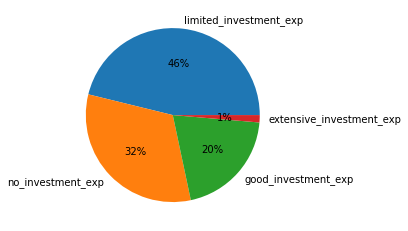

In [25]:
plt.pie(inv_exp_dist, 
        labels=inv_exp_dist.index, 
        autopct='%.0f%%')

In [26]:
# Percentage distribution of liquidity_needs
liq_needs_dist = features_df['liquidity_needs'].value_counts(normalize=True)
liq_needs_dist

very_important_liq_need        0.755193
somewhat_important_liq_need    0.198603
not_important_liq_need         0.046203
Name: liquidity_needs, dtype: float64

Around 76% of the users reported that the importance of liquidity needs is high.<br>
Around 20% of the users reported that the importance of liquidity needs is medium.<br>
Around 4% of the users reported that the liquidity needs are not important to them.<br>

([<matplotlib.patches.Wedge at 0x22753c18610>,
 [Text(-0.7904039193191645, 0.7650239501642441, 'very_important_liq_need'),
  Text(0.6714364235780627, -0.8713054166552051, 'somewhat_important_liq_need'),
  Text(1.0884322676973726, -0.15910750653302067, 'not_important_liq_need')],
 [Text(-0.4311294105377261, 0.4172857909986785, '76%'),
  Text(0.3662380492243978, -0.47525749999374817, '20%'),
  Text(0.5936903278349304, -0.08678591265437491, '5%')])

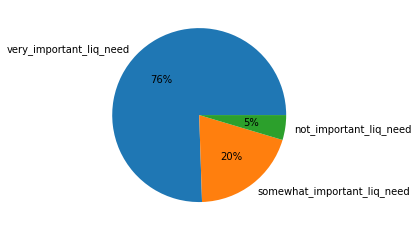

In [27]:
plt.pie(liq_needs_dist, 
        labels=liq_needs_dist.index, 
        autopct='%.0f%%')

In [28]:
# Percentage distribution of platform
platform_dist = features_df['platform'].value_counts(normalize=True)
platform_dist

iOS        0.635745
Android    0.273818
both       0.090437
Name: platform, dtype: float64

Around 64% of the users used iOS.<br>
Around 27% of the users used Android.<br>
Around 9% of the users used both.<br>

([<matplotlib.patches.Wedge at 0x22753c6a0a0>,
 [Text(-0.45501095743288983, 1.001481417009824, 'iOS'),
  Text(0.15604511650861078, -1.0888755308178315, 'Android'),
  Text(1.0559007703782508, -0.30834001218560125, 'both')],
 [Text(-0.24818779496339444, 0.5462625910962676, '64%'),
  Text(0.08511551809560587, -0.5939321077188171, '27%'),
  Text(0.5759458747517731, -0.16818546119214614, '9%')])

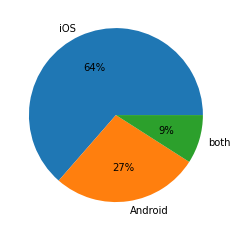

In [29]:
plt.pie(platform_dist, 
        labels=platform_dist.index, 
        autopct='%.0f%%')

In [30]:
# Percentage distribution of instrument_type_first_traded
instrument_dist = features_df['instrument_type_first_traded'].value_counts(normalize=True)
instrument_dist

stock       0.864434
etp         0.068589
adr         0.035279
mlp         0.009850
reit        0.009850
cef         0.003582
wrt         0.002865
0           0.002328
rlt         0.001612
lp          0.001433
tracking    0.000179
Name: instrument_type_first_traded, dtype: float64

Around 86% of the users used stock for their first trading.<br>

In [31]:
# Replacing the category "0" with "unknown"
x = features_df['instrument_type_first_traded']
x = x.str.replace("0", "unknown")
x.value_counts(normalize=True)

stock       0.864434
etp         0.068589
adr         0.035279
mlp         0.009850
reit        0.009850
cef         0.003582
wrt         0.002865
unknown     0.002328
rlt         0.001612
lp          0.001433
tracking    0.000179
Name: instrument_type_first_traded, dtype: float64

<AxesSubplot:xlabel='instrument_type_first_traded', ylabel='count'>

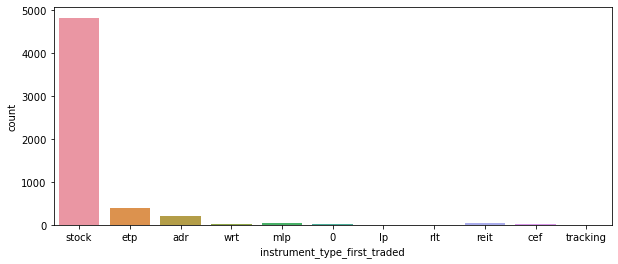

In [32]:
plt.figure(figsize=(10,4))
sns.countplot(data=features_df,
              x=features_df['instrument_type_first_traded'])

In [33]:
# Percentage distribution of time_horizon
time_horizon_dist = features_df['time_horizon'].value_counts(normalize=True)
time_horizon_dist

short_time_horizon    0.507342
long_time_horizon     0.328259
med_time_horizon      0.164398
Name: time_horizon, dtype: float64

Around 51% of the users reported short time investors.<br>
Around 33% of the users reported long time investors.<br>
Around 16% of the users reported medium time investors.<br>

([<matplotlib.patches.Wedge at 0x227545f7490>,
 [Text(-0.025371256498277234, 1.0997073698687752, 'short_time_horizon'),
  Text(-0.5209908414067939, -0.9687974727311386, 'long_time_horizon'),
  Text(0.9565232076382649, -0.5431973428224817, 'med_time_horizon')],
 [Text(-0.013838867180878489, 0.5998403835647863, '51%'),
  Text(-0.28417682258552385, -0.5284349851260756, '33%'),
  Text(0.5217399314390535, -0.2962894597213536, '16%')])

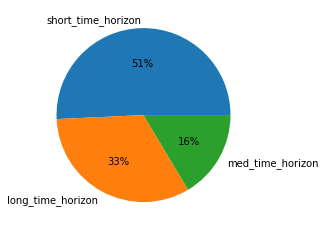

In [34]:
plt.pie(time_horizon_dist, 
        labels=time_horizon_dist.index, 
        autopct='%.0f%%')

In [35]:
print('Number of unique user ids in the features dataframe: {}'.\
      format(features_df['user_id'].nunique()))

Number of unique user ids in the features dataframe: 5584


In [36]:
equity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119158 entries, 0 to 1119157
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   timestamp     1119158 non-null  object 
 1   close_equity  1119158 non-null  float64
 2   user_id       1119158 non-null  object 
dtypes: float64(1), object(2)
memory usage: 25.6+ MB


In [37]:
equity_df['timestamp'] = pd.to_datetime(equity_df['timestamp'])

In [38]:
equity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119158 entries, 0 to 1119157
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype              
---  ------        --------------    -----              
 0   timestamp     1119158 non-null  datetime64[ns, UTC]
 1   close_equity  1119158 non-null  float64            
 2   user_id       1119158 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 25.6+ MB


In [39]:
# Check if any timezone information is present in the timestamp column
has_timezone = equity_df['timestamp'].dt.tz is not None
print("Does timestamp column contains timezone information? {}".\
      format("Yes" if has_timezone else "No"))

Does timestamp column contains timezone information? Yes


In [40]:
# Converting timestamp feature to datetime64 type in pandas as the information given 
# is on day basis.
equity_df['timestamp'] = pd.to_datetime(equity_df['timestamp']).dt.tz_convert(None)

In [41]:
equity_df.sort_values(['user_id', 'timestamp'], inplace=True)

In [42]:
equity_df.head()

,timestamp,close_equity,user_id
505994,2016-08-18,1211.6055,0012db34aa7b083f5714e7831195e54d
505995,2016-08-19,1173.5640,0012db34aa7b083f5714e7831195e54d
505996,2016-08-22,1253.0597,0012db34aa7b083f5714e7831195e54d
505997,2016-08-23,1252.9050,0012db34aa7b083f5714e7831195e54d
505998,2016-08-24,1262.1360,0012db34aa7b083f5714e7831195e54d


#### Assumptions made:

For some users like 002e4653171ddc61c3cd30603cd7bd3e, we see the equity values in equity_data.csv from 2017-02-16. We are not sure whether 
1. the user churned before 2017-02-16 because there are no equity values before 2017-02-16 or
2. the user created their robinhood account on 2017-02-16 and hence we use equity values from 2017-02-16.

We made the second assumption.

In [43]:
user_account_df = equity_df.groupby('user_id')['timestamp'].agg(['min'])
user_account_df.reset_index(inplace=True)
user_account_df = user_account_df.rename(columns={'min': 'account_start_date'})

In [44]:
user_account_df.head()

,user_id,account_start_date
0,0012db34aa7b083f5714e7831195e54d,2016-08-18
1,001d6c77dbdb3213cead7673f250bfdc,2016-08-18
2,002e4653171ddc61c3cd30603cd7bd3e,2017-02-16
3,00384fa9be6fdca1b786bae70d78f88f,2017-02-23
4,0042aac295a0d4df88f4b83012778bd4,2016-08-18


In [45]:
result_dict = user_account_df.groupby('user_id').apply(\
    lambda x: x['account_start_date'].values).to_dict()

In [46]:
len(result_dict)

5584

In [47]:
# Find unique user_id's
users = list(equity_df['user_id'].unique())

In [48]:
data = []
for user in users:
    # Account created date
    #start_date = '2016-08-16' # as per the problem statement
    start_date = np.datetime_as_string(result_dict[user][0]).split('T')[0] # Account created date
    end_date = '2017-08-18' # as per the problem statement

    end_date_inclusive = pd.to_datetime(end_date) + pd.DateOffset(days=1)
    
    # Generate a list of dates ranging from the given start and end dates
    dates = pd.date_range(start=start_date, 
                          end=end_date_inclusive,
                          freq='D')

    user_data = pd.DataFrame({'user_id': user, 
                              'timestamp': dates})
    data.append(user_data)
    
new_df = pd.concat(data, ignore_index=True)

In [49]:
new_df.head()

,user_id,timestamp
0,0012db34aa7b083f5714e7831195e54d,2016-08-18
1,0012db34aa7b083f5714e7831195e54d,2016-08-19
2,0012db34aa7b083f5714e7831195e54d,2016-08-20
3,0012db34aa7b083f5714e7831195e54d,2016-08-21
4,0012db34aa7b083f5714e7831195e54d,2016-08-22


In [50]:
new_df[new_df['user_id'] == '00440034cc4152bfb01b30f5c381c4e3']

,user_id,timestamp
1464,00440034cc4152bfb01b30f5c381c4e3,2016-12-30
1465,00440034cc4152bfb01b30f5c381c4e3,2016-12-31
1466,00440034cc4152bfb01b30f5c381c4e3,2017-01-01
1467,00440034cc4152bfb01b30f5c381c4e3,2017-01-02
1468,00440034cc4152bfb01b30f5c381c4e3,2017-01-03
...,...,...
1692,00440034cc4152bfb01b30f5c381c4e3,2017-08-15
1693,00440034cc4152bfb01b30f5c381c4e3,2017-08-16
1694,00440034cc4152bfb01b30f5c381c4e3,2017-08-17
1695,00440034cc4152bfb01b30f5c381c4e3,2017-08-18


In [51]:
merged_df = new_df.merge(equity_df, 
                         how='left', 
                         on=['user_id', 'timestamp'])
merged_df.head()

,user_id,timestamp,close_equity
0,0012db34aa7b083f5714e7831195e54d,2016-08-18,1211.6055
1,0012db34aa7b083f5714e7831195e54d,2016-08-19,1173.5640
2,0012db34aa7b083f5714e7831195e54d,2016-08-20,NaN
3,0012db34aa7b083f5714e7831195e54d,2016-08-21,NaN
4,0012db34aa7b083f5714e7831195e54d,2016-08-22,1253.0597


In [52]:
# Find the day
merged_df['day'] = merged_df['timestamp'].apply(lambda x: x.day_name())

In [53]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1760090 entries, 0 to 1760089
Data columns (total 4 columns):
 #   Column        Dtype         
---  ------        -----         
 0   user_id       object        
 1   timestamp     datetime64[ns]
 2   close_equity  float64       
 3   day           object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 67.1+ MB


In [54]:
merged_df.head()

,user_id,timestamp,close_equity,day
0,0012db34aa7b083f5714e7831195e54d,2016-08-18,1211.6055,Thursday
1,0012db34aa7b083f5714e7831195e54d,2016-08-19,1173.5640,Friday
2,0012db34aa7b083f5714e7831195e54d,2016-08-20,NaN,Saturday
3,0012db34aa7b083f5714e7831195e54d,2016-08-21,NaN,Sunday
4,0012db34aa7b083f5714e7831195e54d,2016-08-22,1253.0597,Monday


In [55]:
week_end_list = ['Saturday', 'Sunday']
# Getting the records where the equity value is non-null for weekend.
non_null_equity_weekend = (~merged_df['close_equity'].isna()) & \
                          (merged_df['day'].isin(week_end_list))
merged_df[non_null_equity_weekend]

,user_id,timestamp,close_equity,day


The above implies that there are no equity values present for Saturday and Sunday for all users.

In [56]:
merged_df.isna().sum()

user_id              0
timestamp            0
close_equity    640932
day                  0
dtype: int64

In [57]:
# Missing equity values for Saturday and Sunday
non_null_equity_weekend = (merged_df['close_equity'].isna()) & \
                          (merged_df['day'].isin(week_end_list))
merged_df[non_null_equity_weekend]

,user_id,timestamp,close_equity,day
2,0012db34aa7b083f5714e7831195e54d,2016-08-20,NaN,Saturday
3,0012db34aa7b083f5714e7831195e54d,2016-08-21,NaN,Sunday
9,0012db34aa7b083f5714e7831195e54d,2016-08-27,NaN,Saturday
10,0012db34aa7b083f5714e7831195e54d,2016-08-28,NaN,Sunday
16,0012db34aa7b083f5714e7831195e54d,2016-09-03,NaN,Saturday
...,...,...,...,...
1760075,ffc1e622f3a0b2666f09a6dcb7f27918,2017-08-05,NaN,Saturday
1760076,ffc1e622f3a0b2666f09a6dcb7f27918,2017-08-06,NaN,Sunday
1760082,ffc1e622f3a0b2666f09a6dcb7f27918,2017-08-12,NaN,Saturday
1760083,ffc1e622f3a0b2666f09a6dcb7f27918,2017-08-13,NaN,Sunday


In [58]:
# Missing equity values for days other than Saturday and Sunday
non_null_equity_weekend = (merged_df['close_equity'].isna()) & \
                          (~merged_df['day'].isin(week_end_list))
merged_df[non_null_equity_weekend]

,user_id,timestamp,close_equity,day
18,0012db34aa7b083f5714e7831195e54d,2016-09-05,NaN,Monday
98,0012db34aa7b083f5714e7831195e54d,2016-11-24,NaN,Thursday
130,0012db34aa7b083f5714e7831195e54d,2016-12-26,NaN,Monday
137,0012db34aa7b083f5714e7831195e54d,2017-01-02,NaN,Monday
151,0012db34aa7b083f5714e7831195e54d,2017-01-16,NaN,Monday
...,...,...,...,...
1759874,ffc1e622f3a0b2666f09a6dcb7f27918,2017-01-16,NaN,Monday
1759909,ffc1e622f3a0b2666f09a6dcb7f27918,2017-02-20,NaN,Monday
1759962,ffc1e622f3a0b2666f09a6dcb7f27918,2017-04-14,NaN,Friday
1760007,ffc1e622f3a0b2666f09a6dcb7f27918,2017-05-29,NaN,Monday


We can say that the equity values had gone below $10 in the days for the users which is not provided in equity_data.csv

We assume the equity values to be 9.0(anything below 10) if there are missing dates in the equity dataframe for each user during week days.    


In [59]:
# We impute $9 for missing equity values for week days.
impute_value = 9.0

condition = (merged_df['close_equity'].isna()) & (~merged_df['day'].isin(week_end_list))
merged_df.loc[condition, 'close_equity'] = impute_value


In [60]:
merged_df.isna().sum()

user_id              0
timestamp            0
close_equity    502830
day                  0
dtype: int64

In [61]:
# Getting the records where the equity value is null for weekend.
null_equity_weekend = (merged_df['close_equity'].isna()) & \
                          (merged_df['day'].isin(week_end_list))
merged_df[null_equity_weekend]

,user_id,timestamp,close_equity,day
2,0012db34aa7b083f5714e7831195e54d,2016-08-20,NaN,Saturday
3,0012db34aa7b083f5714e7831195e54d,2016-08-21,NaN,Sunday
9,0012db34aa7b083f5714e7831195e54d,2016-08-27,NaN,Saturday
10,0012db34aa7b083f5714e7831195e54d,2016-08-28,NaN,Sunday
16,0012db34aa7b083f5714e7831195e54d,2016-09-03,NaN,Saturday
...,...,...,...,...
1760075,ffc1e622f3a0b2666f09a6dcb7f27918,2017-08-05,NaN,Saturday
1760076,ffc1e622f3a0b2666f09a6dcb7f27918,2017-08-06,NaN,Sunday
1760082,ffc1e622f3a0b2666f09a6dcb7f27918,2017-08-12,NaN,Saturday
1760083,ffc1e622f3a0b2666f09a6dcb7f27918,2017-08-13,NaN,Sunday


Equity values are missing for Saturday and Sunday as there is no trading happening during weekend. Hence we impute missing equity values for Saturday and Sunday from Friday of the same week.

In [62]:
for user in users:
    each_user_df = merged_df[merged_df['user_id'] == user]
    condition = (each_user_df['close_equity'].isna()) & \
                  (each_user_df['day'].isin(week_end_list))

    # Use forward fill to copy the equity values from Friday to Saturday and Sunday.
    each_user_df['close_equity'] = np.where(condition, 
                                            each_user_df['close_equity'].ffill(), 
                                            each_user_df['close_equity'])
    merged_df[merged_df['user_id'] == user] = each_user_df
    #merged_df.update(each_user_df)

In [63]:
merged_df.isna().sum()

user_id         0
timestamp       0
close_equity    0
day             0
dtype: int64

In [64]:
merged_df[merged_df['close_equity'].isna()]

,user_id,timestamp,close_equity,day


In [65]:
merged_df[merged_df['close_equity'].isna()]

,user_id,timestamp,close_equity,day


In [66]:
print('Are there any duplicate rows in the dataframe: {}'.\
      format(len(merged_df[merged_df.duplicated()])))

Are there any duplicate rows in the dataframe: 0


In [67]:
merged_df.loc[0:10]

,user_id,timestamp,close_equity,day
0,0012db34aa7b083f5714e7831195e54d,2016-08-18,1211.6055,Thursday
1,0012db34aa7b083f5714e7831195e54d,2016-08-19,1173.5640,Friday
2,0012db34aa7b083f5714e7831195e54d,2016-08-20,1173.5640,Saturday
3,0012db34aa7b083f5714e7831195e54d,2016-08-21,1173.5640,Sunday
4,0012db34aa7b083f5714e7831195e54d,2016-08-22,1253.0597,Monday
5,0012db34aa7b083f5714e7831195e54d,2016-08-23,1252.9050,Tuesday
6,0012db34aa7b083f5714e7831195e54d,2016-08-24,1262.1360,Wednesday
7,0012db34aa7b083f5714e7831195e54d,2016-08-25,1226.4250,Thursday
8,0012db34aa7b083f5714e7831195e54d,2016-08-26,1227.9610,Friday
9,0012db34aa7b083f5714e7831195e54d,2016-08-27,1227.9610,Saturday


In [68]:
merged_df['close_equity'].describe().apply(lambda x: '{0:.2f}'.format(x))

count    1760090.00
mean        3548.91
std        12409.89
min            9.00
25%           60.88
50%          434.55
75%         2131.22
max       478948.41
Name: close_equity, dtype: object

In [69]:
merged_df.head()

,user_id,timestamp,close_equity,day
0,0012db34aa7b083f5714e7831195e54d,2016-08-18,1211.6055,Thursday
1,0012db34aa7b083f5714e7831195e54d,2016-08-19,1173.5640,Friday
2,0012db34aa7b083f5714e7831195e54d,2016-08-20,1173.5640,Saturday
3,0012db34aa7b083f5714e7831195e54d,2016-08-21,1173.5640,Sunday
4,0012db34aa7b083f5714e7831195e54d,2016-08-22,1253.0597,Monday


In [70]:
user_churn_count = {}
user_churn_window = {}
user_active_window = {}
user_avg_equity_val = {}

In [73]:
def find_complement_intervals(start, end, subintervals):
    complement_intervals = []
       
    if len(subintervals):
        # Check if the start is greater than the first subinterval's start
        if start < subintervals[0][0]:
            complement_intervals.append([start, subintervals[0][0] - 1])

        # Iterate over the subintervals and find the gaps between them
        for i in range(len(subintervals) - 1):
            if subintervals[i][1] < subintervals[i + 1][0]:
                complement_intervals.append([subintervals[i][1] + 1, subintervals[i + 1][0] - 1])

        # Check if the end is less than the last subinterval's end
        if end > subintervals[-1][1]:
            complement_intervals.append([subintervals[-1][1] + 1, end])
    else:
        complement_intervals.append([start, end])
        
    return complement_intervals

In [74]:
def detect_churn_period(each_user_df, window_size):    
    user_id = each_user_df['user_id'].unique()[0]        

    min_index_value = min(each_user_df.index.values)
    max_index_value = max(each_user_df.index.values)
    
    # Create a boolean mask indicating that the equity value is less than 10
    mask = each_user_df['close_equity'] < 10.0
    churn_window_indices =[]
    
    # Iterate over the rolling windows and find the consecutive churn windows
    for i in range(min_index_value, min_index_value+ len(mask) - window_size + 1):
        start = i
        end = i + window_size - 1
        
        # Extract the records of window size.
        mask_start = start-min_index_value
        mask_end = start-min_index_value+window_size-1        
        window = mask[mask_start:mask_end+1]
        
        if all(window): # Condition satisfied for all of the records in the current window
            if len(churn_window_indices): # Previous churn window exists for this user               
                last_churn_window = churn_window_indices[-1]
                # Is there an overlap?
                if last_churn_window[0] < i <= last_churn_window[1]:
                    # Only updte the end interval from previous window
                    churn_window_indices[-1][1] = end
                else: # No overlap
                    churn_window_indices.append([start, end])
            else:
                churn_window_indices.append([start, end])   
                #print(f'Churn : {churn_window_indices}')

    user_churn_window[user_id] = churn_window_indices               
    user_churn_count[user_id] = len(churn_window_indices) 
    user_active_window[user_id] = find_complement_intervals(min_index_value, 
                                                            max_index_value, 
                                                            churn_window_indices)
    if len(churn_window_indices) > 1:
        print(f'Multiple churn windows detected!!!!!!!!!!!')        
        print(f'User id: {user_id}')
        
        print(f'Min index value: {min_index_value}')
        print(f'Max index value: {max_index_value}')

        print('Churn window')
        print(user_churn_window[user_id])
        print('Active window')        
        print(user_active_window[user_id])
        print('**************************************************')

In [75]:
merged_df[(merged_df['user_id'] == '1f1805c0755fdff87a464a8196382c28') & (merged_df['close_equity'] < 10)]

,user_id,timestamp,close_equity,day
209704,1f1805c0755fdff87a464a8196382c28,2016-09-05,9.0,Monday
209784,1f1805c0755fdff87a464a8196382c28,2016-11-24,9.0,Thursday
209816,1f1805c0755fdff87a464a8196382c28,2016-12-26,9.0,Monday
209823,1f1805c0755fdff87a464a8196382c28,2017-01-02,9.0,Monday
209837,1f1805c0755fdff87a464a8196382c28,2017-01-16,9.0,Monday
209872,1f1805c0755fdff87a464a8196382c28,2017-02-20,9.0,Monday
209925,1f1805c0755fdff87a464a8196382c28,2017-04-14,9.0,Friday
209926,1f1805c0755fdff87a464a8196382c28,2017-04-15,9.0,Saturday
209927,1f1805c0755fdff87a464a8196382c28,2017-04-16,9.0,Sunday
209970,1f1805c0755fdff87a464a8196382c28,2017-05-29,9.0,Monday


In [76]:
merged_df[merged_df['user_id'] == '1f1805c0755fdff87a464a8196382c28']

,user_id,timestamp,close_equity,day
209687,1f1805c0755fdff87a464a8196382c28,2016-08-19,1989.61,Friday
209688,1f1805c0755fdff87a464a8196382c28,2016-08-20,1989.61,Saturday
209689,1f1805c0755fdff87a464a8196382c28,2016-08-21,1989.61,Sunday
209690,1f1805c0755fdff87a464a8196382c28,2016-08-22,1979.43,Monday
209691,1f1805c0755fdff87a464a8196382c28,2016-08-23,1982.68,Tuesday
...,...,...,...,...
210048,1f1805c0755fdff87a464a8196382c28,2017-08-15,2426.07,Tuesday
210049,1f1805c0755fdff87a464a8196382c28,2017-08-16,2420.61,Wednesday
210050,1f1805c0755fdff87a464a8196382c28,2017-08-17,2354.68,Thursday
210051,1f1805c0755fdff87a464a8196382c28,2017-08-18,2297.50,Friday


In [77]:
window_size = 28
for user in users:
    filtered_user_df = merged_df[merged_df['user_id'] == user]
    detect_churn_period(filtered_user_df, window_size)

Multiple churn windows detected!!!!!!!!!!!
User id: 028367ff3cbcc04c2afc2ce3336c00e2
Min index value: 14032
Max index value: 14310
Churn window
[[14033, 14066], [14116, 14146], [14148, 14310]]
Active window
[[14032, 14032], [14067, 14115], [14147, 14147]]
**************************************************
Multiple churn windows detected!!!!!!!!!!!
User id: 0423b88554cedaa7efd8dd4c81774cce
Min index value: 28026
Max index value: 28328
Churn window
[[28032, 28095], [28171, 28301]]
Active window
[[28026, 28031], [28096, 28170], [28302, 28328]]
**************************************************
Multiple churn windows detected!!!!!!!!!!!
User id: 062ea0ff3b7fc36ae471968aced1f4a1
Min index value: 40392
Max index value: 40758
Churn window
[[40421, 40558], [40620, 40758]]
Active window
[[40392, 40420], [40559, 40619]]
**************************************************
Multiple churn windows detected!!!!!!!!!!!
User id: 06b894b1cc7bb832284efa097c122e2a
Min index value: 43659
Max index value: 44

Multiple churn windows detected!!!!!!!!!!!
User id: 4db4db8398496203a7def94692739f86
Min index value: 525595
Max index value: 525946
Churn window
[[525780, 525824], [525829, 525894], [525902, 525946]]
Active window
[[525595, 525779], [525825, 525828], [525895, 525901]]
**************************************************
Multiple churn windows detected!!!!!!!!!!!
User id: 4e0972689a7ee96f2146d55ff06d6512
Min index value: 527668
Max index value: 528033
Churn window
[[527797, 527867], [527874, 528033]]
Active window
[[527668, 527796], [527868, 527873]]
**************************************************
Multiple churn windows detected!!!!!!!!!!!
User id: 50b846ab40078ae27b0bf7d6004c9a28
Min index value: 548614
Max index value: 548981
Churn window
[[548669, 548716], [548718, 548752], [548763, 548809]]
Active window
[[548614, 548668], [548717, 548717], [548753, 548762], [548810, 548981]]
**************************************************
Multiple churn windows detected!!!!!!!!!!!
User id: 560

Multiple churn windows detected!!!!!!!!!!!
User id: 798ea74a47a868e2394403abb6b4ef62
Min index value: 821951
Max index value: 822164
Churn window
[[821995, 822047], [822049, 822148]]
Active window
[[821951, 821994], [822048, 822048], [822149, 822164]]
**************************************************
Multiple churn windows detected!!!!!!!!!!!
User id: 79bff70c92dcbdafddc0d37d34bc528d
Min index value: 823262
Max index value: 823628
Churn window
[[823287, 823325], [823539, 823604]]
Active window
[[823262, 823286], [823326, 823538], [823605, 823628]]
**************************************************
Multiple churn windows detected!!!!!!!!!!!
User id: 7edbb45bec57daf79c0262cdba0be869
Min index value: 858405
Max index value: 858771
Churn window
[[858453, 858564], [858697, 858753]]
Active window
[[858405, 858452], [858565, 858696], [858754, 858771]]
**************************************************
Multiple churn windows detected!!!!!!!!!!!
User id: 7fafe2fbca869d4bc998e95398305022
Min in

Multiple churn windows detected!!!!!!!!!!!
User id: b65ab49d8f20fa55d8b0a387184d1525
Min index value: 1245350
Max index value: 1245711
Churn window
[[1245370, 1245407], [1245433, 1245519]]
Active window
[[1245350, 1245369], [1245408, 1245432], [1245520, 1245711]]
**************************************************
Multiple churn windows detected!!!!!!!!!!!
User id: b68798cb2c64254d01481347d70f0290
Min index value: 1246447
Max index value: 1246723
Churn window
[[1246455, 1246495], [1246624, 1246668]]
Active window
[[1246447, 1246454], [1246496, 1246623], [1246669, 1246723]]
**************************************************
Multiple churn windows detected!!!!!!!!!!!
User id: bbd6d6162717a32c2a9266fc10a790a7
Min index value: 1284608
Max index value: 1284974
Churn window
[[1284711, 1284809], [1284846, 1284929]]
Active window
[[1284608, 1284710], [1284810, 1284845], [1284930, 1284974]]
**************************************************
Multiple churn windows detected!!!!!!!!!!!
User id: c06

Multiple churn windows detected!!!!!!!!!!!
User id: f97628bf1b525e526a094654ba001cde
Min index value: 1714959
Max index value: 1715325
Churn window
[[1715107, 1715152], [1715216, 1715325]]
Active window
[[1714959, 1715106], [1715153, 1715215]]
**************************************************
Multiple churn windows detected!!!!!!!!!!!
User id: fb35f2d4f7bd6c9e4085856fe14e8d89
Min index value: 1725962
Max index value: 1726324
Churn window
[[1725990, 1726019], [1726197, 1726324]]
Active window
[[1725962, 1725989], [1726020, 1726196]]
**************************************************
Multiple churn windows detected!!!!!!!!!!!
User id: fbec3cca892e02e38d31aea039989a61
Min index value: 1731373
Max index value: 1731738
Churn window
[[1731384, 1731426], [1731594, 1731738]]
Active window
[[1731373, 1731383], [1731427, 1731593]]
**************************************************


In [78]:
user_account_df['churn_count'] = user_account_df['user_id'].map(user_churn_count)
user_account_df['churn_period'] = user_account_df['user_id'].map(user_churn_window)
user_account_df['active_period'] = user_account_df['user_id'].map(user_active_window)

In [79]:
user_account_df['active_period_count'] = user_account_df['active_period'].apply(\
                                                             lambda x: len(x))

In [80]:
user_account_df.head()

,user_id,account_start_date,churn_count,churn_period,active_period,active_period_count
0,0012db34aa7b083f5714e7831195e54d,2016-08-18,0,[],"[[0, 366]]",1
1,001d6c77dbdb3213cead7673f250bfdc,2016-08-18,0,[],"[[367, 733]]",1
2,002e4653171ddc61c3cd30603cd7bd3e,2017-02-16,0,[],"[[734, 918]]",1
3,00384fa9be6fdca1b786bae70d78f88f,2017-02-23,0,[],"[[919, 1096]]",1
4,0042aac295a0d4df88f4b83012778bd4,2016-08-18,0,[],"[[1097, 1463]]",1


In [81]:
user_account_df['churn_count'].value_counts()

0    4586
1     883
2     104
3      11
Name: churn_count, dtype: int64

In [82]:
user_account_df['account_age_in_days'] = (pd.to_datetime('2017-08-18') - \
                                         user_account_df['account_start_date']).dt.days + 1

In [83]:
user_account_df['churn'] = np.where(user_account_df['churn_count'] >= 1, 'yes', 'no')

In [84]:
user_account_df['churn'].value_counts()

no     4586
yes     998
Name: churn, dtype: int64

In [85]:
churn_users = user_account_df['churn'].value_counts()[1]
non_churn_users = user_account_df['churn'].value_counts()[0]

all_users = churn_users + non_churn_users
print(f'Number of churn users: {churn_users}')
print(f'Total numbers of users: {all_users}')

churn_percentage = round((churn_users/all_users) * 100, 2)
print(f'Percentage of users churned: {churn_percentage}%')

Number of churn users: 998
Total numbers of users: 5584
Percentage of users churned: 17.87%


In [86]:
user_account_df.head()

,user_id,account_start_date,churn_count,churn_period,active_period,active_period_count,account_age_in_days,churn
0,0012db34aa7b083f5714e7831195e54d,2016-08-18,0,[],"[[0, 366]]",1,366,no
1,001d6c77dbdb3213cead7673f250bfdc,2016-08-18,0,[],"[[367, 733]]",1,366,no
2,002e4653171ddc61c3cd30603cd7bd3e,2017-02-16,0,[],"[[734, 918]]",1,184,no
3,00384fa9be6fdca1b786bae70d78f88f,2017-02-23,0,[],"[[919, 1096]]",1,177,no
4,0042aac295a0d4df88f4b83012778bd4,2016-08-18,0,[],"[[1097, 1463]]",1,366,no


In [87]:
user_account_df['avg_equity_active'] = 0
user_account_df['stddev_equity_active'] = 0
user_account_df['avg_active_days'] = 0
user_account_df['avg_churn_days'] = 0

In [88]:
# Iterate over each of the records of user_account_df
for user_index, user in user_account_df.iterrows():
    #print(user['user_id'])
    
    avg_active_days = []
    avg_churn_days = []
    avg_equity_active = []
    std_equity_active = []
    
    # Extract the range of indices from the column    
    indices_range = user['active_period']
    for indices in indices_range:
        start_index, end_index = indices
        avg_active_days.append(end_index - start_index + 1)
        avg_equity_active.append(np.mean(merged_df.iloc[start_index:end_index+1]['close_equity']))
        std_equity_active.append(np.std(merged_df.iloc[start_index:end_index+1]['close_equity']))
        
    churn_indices_range = user['churn_period']    
    for indices in churn_indices_range:
        start_index, end_index = indices
        avg_churn_days.append(end_index - start_index + 1)
        
    if len(avg_equity_active):
        user_account_df.loc[user_index, 'avg_equity_active'] = \
                                        sum(avg_equity_active)/len(avg_equity_active)
    if len(std_equity_active):
        user_account_df.loc[user_index, 'stddev_equity_active'] = \
                                        sum(std_equity_active)/len(std_equity_active)
    if len(avg_active_days):
        user_account_df.loc[user_index, 'avg_active_days'] = \
                                        sum(avg_active_days)/len(avg_active_days)
    if len(avg_churn_days):
        user_account_df.loc[user_index, 'avg_churn_days'] = \
                                        sum(avg_churn_days)/len(avg_churn_days)

In [89]:
user_account_df.head(20)

,user_id,account_start_date,churn_count,churn_period,active_period,active_period_count,account_age_in_days,churn,avg_equity_active,stddev_equity_active,avg_active_days,avg_churn_days
0,0012db34aa7b083f5714e7831195e54d,2016-08-18,0,[],"[[0, 366]]",1,366,no,587.735576,218.226340,367.0,0.0
1,001d6c77dbdb3213cead7673f250bfdc,2016-08-18,0,[],"[[367, 733]]",1,366,no,3186.885604,751.496671,367.0,0.0
2,002e4653171ddc61c3cd30603cd7bd3e,2017-02-16,0,[],"[[734, 918]]",1,184,no,113.668216,20.181309,185.0,0.0
3,00384fa9be6fdca1b786bae70d78f88f,2017-02-23,0,[],"[[919, 1096]]",1,177,no,449.798455,78.678600,178.0,0.0
4,0042aac295a0d4df88f4b83012778bd4,2016-08-18,0,[],"[[1097, 1463]]",1,366,no,1507.224269,960.103419,367.0,0.0
5,00440034cc4152bfb01b30f5c381c4e3,2016-12-30,1,"[[1524, 1602]]","[[1464, 1523], [1603, 1696]]",2,232,yes,58.505101,22.497249,77.0,79.0
6,004aab1640f3a04b87b1f404fb4c018d,2017-01-13,1,"[[1805, 1915]]","[[1697, 1804]]",1,218,yes,19.920463,6.698241,108.0,111.0
7,004ea9d7662aa8dc840bbff212cfa4b8,2017-02-28,1,"[[2049, 2088]]","[[1916, 2048]]",1,172,yes,92.512519,16.743220,133.0,40.0
8,005d630a68b4ab3a2f4cd49d9a87c50d,2016-08-18,1,"[[2170, 2289]]","[[2089, 2169], [2290, 2455]]",2,366,yes,100.230222,10.923810,123.5,120.0
9,00a9602e72eb34cb17aaad6ce62730b6,2016-08-17,0,[],"[[2456, 2823]]",1,367,no,131.820422,27.941759,368.0,0.0


In [90]:
user_account_df['churn_count'].value_counts()

0    4586
1     883
2     104
3      11
Name: churn_count, dtype: int64

In [91]:
user_account_df['churn'].value_counts()

no     4586
yes     998
Name: churn, dtype: int64

In [92]:
churn_dist = user_account_df['churn'].value_counts(normalize=True)
churn_dist

no     0.821275
yes    0.178725
Name: churn, dtype: float64

<AxesSubplot:title={'center':'Frequency distribution of churn users'}, xlabel='churn', ylabel='count'>

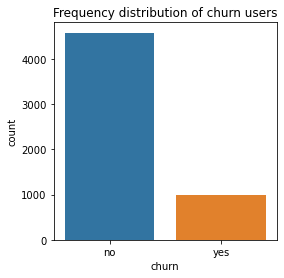

In [93]:
plt.figure(figsize=(4,4))
plt.title('Frequency distribution of churn users')
sns.countplot(data=user_account_df, x='churn')

In [94]:
user_account_df.head()

,user_id,account_start_date,churn_count,churn_period,active_period,active_period_count,account_age_in_days,churn,avg_equity_active,stddev_equity_active,avg_active_days,avg_churn_days
0,0012db34aa7b083f5714e7831195e54d,2016-08-18,0,[],"[[0, 366]]",1,366,no,587.735576,218.226340,367.0,0.0
1,001d6c77dbdb3213cead7673f250bfdc,2016-08-18,0,[],"[[367, 733]]",1,366,no,3186.885604,751.496671,367.0,0.0
2,002e4653171ddc61c3cd30603cd7bd3e,2017-02-16,0,[],"[[734, 918]]",1,184,no,113.668216,20.181309,185.0,0.0
3,00384fa9be6fdca1b786bae70d78f88f,2017-02-23,0,[],"[[919, 1096]]",1,177,no,449.798455,78.678600,178.0,0.0
4,0042aac295a0d4df88f4b83012778bd4,2016-08-18,0,[],"[[1097, 1463]]",1,366,no,1507.224269,960.103419,367.0,0.0


In [95]:
user_account_df.shape

(5584, 12)

In [96]:
user_account_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               5584 non-null   object        
 1   account_start_date    5584 non-null   datetime64[ns]
 2   churn_count           5584 non-null   int64         
 3   churn_period          5584 non-null   object        
 4   active_period         5584 non-null   object        
 5   active_period_count   5584 non-null   int64         
 6   account_age_in_days   5584 non-null   int64         
 7   churn                 5584 non-null   object        
 8   avg_equity_active     5584 non-null   float64       
 9   stddev_equity_active  5584 non-null   float64       
 10  avg_active_days       5584 non-null   float64       
 11  avg_churn_days        5584 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(3), object(4)
memory usage: 523.6+ K

In [97]:
features_df.shape

(5584, 9)

In [98]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   risk_tolerance                5584 non-null   object 
 1   investment_experience         5584 non-null   object 
 2   liquidity_needs               5584 non-null   object 
 3   platform                      5584 non-null   object 
 4   time_spent                    5584 non-null   float64
 5   instrument_type_first_traded  5584 non-null   object 
 6   first_deposit_amount          5584 non-null   float64
 7   time_horizon                  5584 non-null   object 
 8   user_id                       5584 non-null   object 
dtypes: float64(2), object(7)
memory usage: 392.8+ KB


In [99]:
user_account_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               5584 non-null   object        
 1   account_start_date    5584 non-null   datetime64[ns]
 2   churn_count           5584 non-null   int64         
 3   churn_period          5584 non-null   object        
 4   active_period         5584 non-null   object        
 5   active_period_count   5584 non-null   int64         
 6   account_age_in_days   5584 non-null   int64         
 7   churn                 5584 non-null   object        
 8   avg_equity_active     5584 non-null   float64       
 9   stddev_equity_active  5584 non-null   float64       
 10  avg_active_days       5584 non-null   float64       
 11  avg_churn_days        5584 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(3), object(4)
memory usage: 523.6+ K

In [100]:
final_df = pd.merge(features_df[['user_id',
                                 'risk_tolerance',
                                 'investment_experience',
                                 'liquidity_needs',
                                 'platform',
                                 'time_spent',
                                 'instrument_type_first_traded',
                                 'first_deposit_amount',
                                 'time_horizon']], 
                    user_account_df[['user_id',
                                     'account_age_in_days', 
                                     'churn_count',
                                     'avg_churn_days', 
                                     'active_period_count',                                     
                                     'avg_active_days',
                                     'avg_equity_active',
                                     'stddev_equity_active',
                                     'churn']], 
                    how='inner', 
                    on='user_id')
final_df.head()

,user_id,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,account_age_in_days,churn_count,avg_churn_days,active_period_count,avg_active_days,avg_equity_active,stddev_equity_active,churn
0,895044c23edc821881e87da749c01034,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,276,0,0.0,1,277.0,74.595451,16.506859,no
1,458b1d95441ced242949deefe8e4b638,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,366,0,0.0,1,367.0,338.948529,68.194057,no
2,c7936f653d293479e034865db9bb932f,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,366,0,0.0,1,367.0,47.814605,7.438155,no
3,b255d4bd6c9ba194d3a350b3e76c6393,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,205,0,0.0,1,206.0,180.224709,32.373018,no
4,4a168225e89375b8de605cbc0977ae91,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,365,0,0.0,1,366.0,200.645666,146.480313,no


In [101]:
print(f'Number of observations in the final dataframe: {final_df.shape[0]}')
print(f'Number of features in the final dataframe: {final_df.shape[1]}')

Number of observations in the final dataframe: 5584
Number of features in the final dataframe: 17


In [102]:
# Check for any missing values in the final dataframe after merging
final_df.isna().sum()

user_id                         0
risk_tolerance                  0
investment_experience           0
liquidity_needs                 0
platform                        0
time_spent                      0
instrument_type_first_traded    0
first_deposit_amount            0
time_horizon                    0
account_age_in_days             0
churn_count                     0
avg_churn_days                  0
active_period_count             0
avg_active_days                 0
avg_equity_active               0
stddev_equity_active            0
churn                           0
dtype: int64

In [103]:
print('Are there any duplicate rows in the final dataframe after merging: {}'.\
      format(len(final_df[final_df.duplicated()])))

Are there any duplicate rows in the final dataframe after merging: 0


In [104]:
final_df.to_csv('final_merged_df_updated.csv', index=False)

## 1.2 Bivariate Analysis

In [153]:
final_df = pd.read_csv('final_merged_df_updated.csv')

In [154]:
final_df.head()

,user_id,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,account_age_in_days,churn_count,avg_churn_days,active_period_count,avg_active_days,avg_equity_active,stddev_equity_active,churn
0,895044c23edc821881e87da749c01034,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,276,0,0.0,1,277.0,74.595451,16.506859,no
1,458b1d95441ced242949deefe8e4b638,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,366,0,0.0,1,367.0,338.948529,68.194057,no
2,c7936f653d293479e034865db9bb932f,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,366,0,0.0,1,367.0,47.814605,7.438155,no
3,b255d4bd6c9ba194d3a350b3e76c6393,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,205,0,0.0,1,206.0,180.224709,32.373018,no
4,4a168225e89375b8de605cbc0977ae91,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,365,0,0.0,1,366.0,200.645666,146.480313,no


<AxesSubplot:xlabel='risk_tolerance', ylabel='count'>

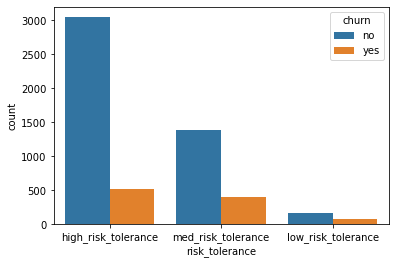

In [155]:
sns.countplot(x='risk_tolerance', hue='churn', data=final_df)

<AxesSubplot:xlabel='investment_experience', ylabel='count'>

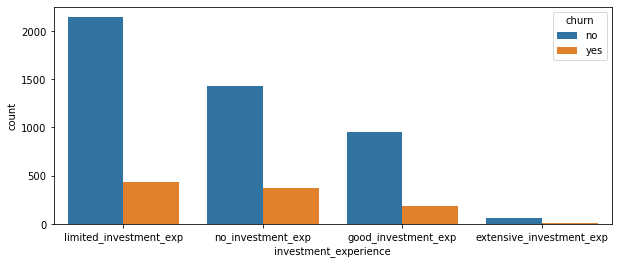

In [156]:
plt.figure(figsize=(10,4))
sns.countplot(x='investment_experience', hue='churn', data=final_df)

<AxesSubplot:xlabel='liquidity_needs', ylabel='count'>

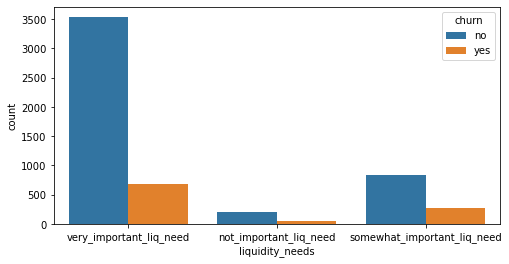

In [157]:
plt.figure(figsize=(8,4))
sns.countplot(x='liquidity_needs', hue='churn', data=final_df)

<AxesSubplot:xlabel='platform', ylabel='count'>

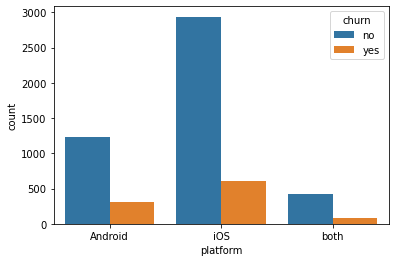

In [158]:
sns.countplot(x='platform', hue='churn', data=final_df)

<AxesSubplot:xlabel='instrument_type_first_traded', ylabel='count'>

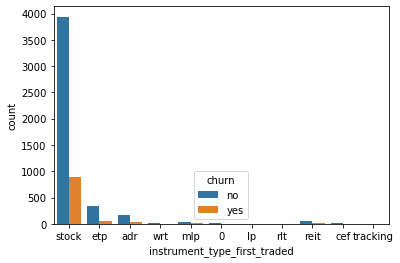

In [159]:
sns.countplot(x='instrument_type_first_traded', hue='churn', data=final_df)

<AxesSubplot:xlabel='time_horizon', ylabel='count'>

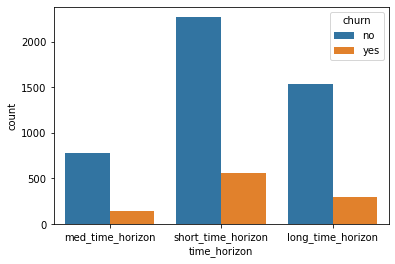

In [160]:
sns.countplot(x='time_horizon', hue='churn', data=final_df)

<AxesSubplot:xlabel='churn', ylabel='time_spent'>

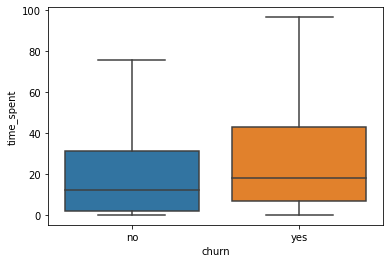

In [161]:
sns.boxplot(x='churn',y='time_spent',data=final_df, showfliers=False)

<AxesSubplot:xlabel='churn', ylabel='first_deposit_amount'>

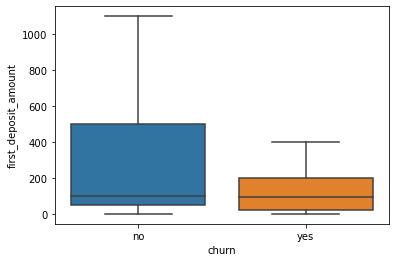

In [162]:
sns.boxplot(x='churn',y='first_deposit_amount',data=final_df, showfliers=False)

<AxesSubplot:xlabel='churn', ylabel='account_age_in_days'>

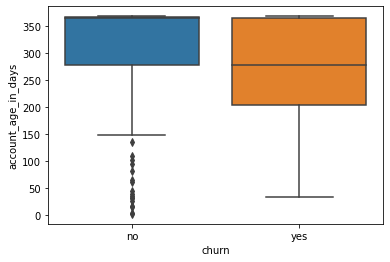

In [163]:
sns.boxplot(x='churn',y='account_age_in_days',data=final_df)

<AxesSubplot:xlabel='churn', ylabel='avg_active_days'>

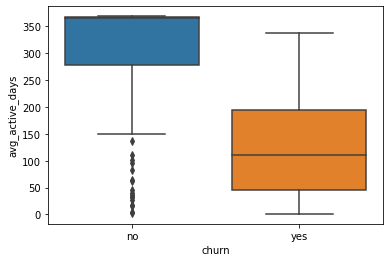

In [164]:
sns.boxplot(x='churn',y='avg_active_days',data=final_df)

<AxesSubplot:xlabel='churn', ylabel='avg_churn_days'>

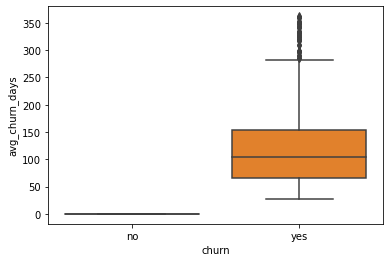

In [165]:
sns.boxplot(x='churn',y='avg_churn_days',data=final_df)

<AxesSubplot:xlabel='churn', ylabel='avg_equity_active'>

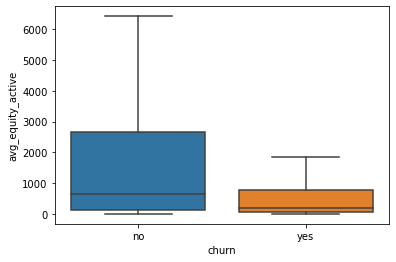

In [166]:
sns.boxplot(x='churn',y='avg_equity_active',data=final_df, showfliers=False)

<AxesSubplot:xlabel='churn', ylabel='stddev_equity_active'>

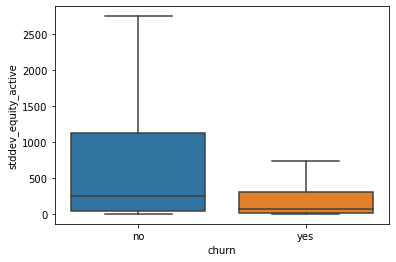

In [167]:
sns.boxplot(x='churn',y='stddev_equity_active',data=final_df, showfliers=False)

In [168]:
corr_matrix = final_df.corr()
corr_matrix

,time_spent,first_deposit_amount,account_age_in_days,churn_count,avg_churn_days,active_period_count,avg_active_days,avg_equity_active,stddev_equity_active
time_spent,1.000000,-0.000770,-0.072224,0.026536,0.022357,-0.005503,-0.058459,-0.006346,0.002414
first_deposit_amount,-0.000770,1.000000,0.073517,-0.068222,-0.062233,-0.030780,0.090132,0.352219,0.291828
account_age_in_days,-0.072224,0.073517,1.000000,-0.187197,-0.197231,-0.010382,0.774597,0.117430,0.101684
churn_count,0.026536,-0.068222,-0.187197,1.000000,0.765582,0.645442,-0.702755,-0.094137,-0.089409
avg_churn_days,0.022357,-0.062233,-0.197231,0.765582,1.000000,0.242034,-0.703010,-0.088166,-0.085206
active_period_count,-0.005503,-0.030780,-0.010382,0.645442,0.242034,1.000000,-0.411464,-0.045330,-0.043191
avg_active_days,-0.058459,0.090132,0.774597,-0.702755,-0.703010,-0.411464,1.000000,0.137760,0.124709
avg_equity_active,-0.006346,0.352219,0.117430,-0.094137,-0.088166,-0.045330,0.137760,1.000000,0.873405
stddev_equity_active,0.002414,0.291828,0.101684,-0.089409,-0.085206,-0.043191,0.124709,0.873405,1.000000


<AxesSubplot:>

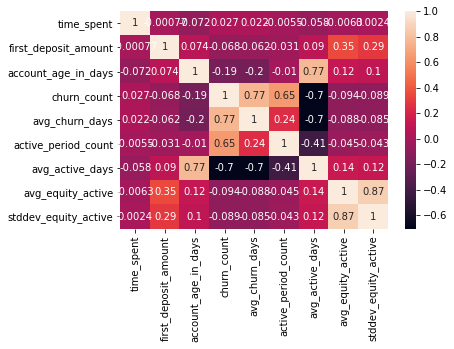

In [169]:
sns.heatmap(corr_matrix, annot=True)

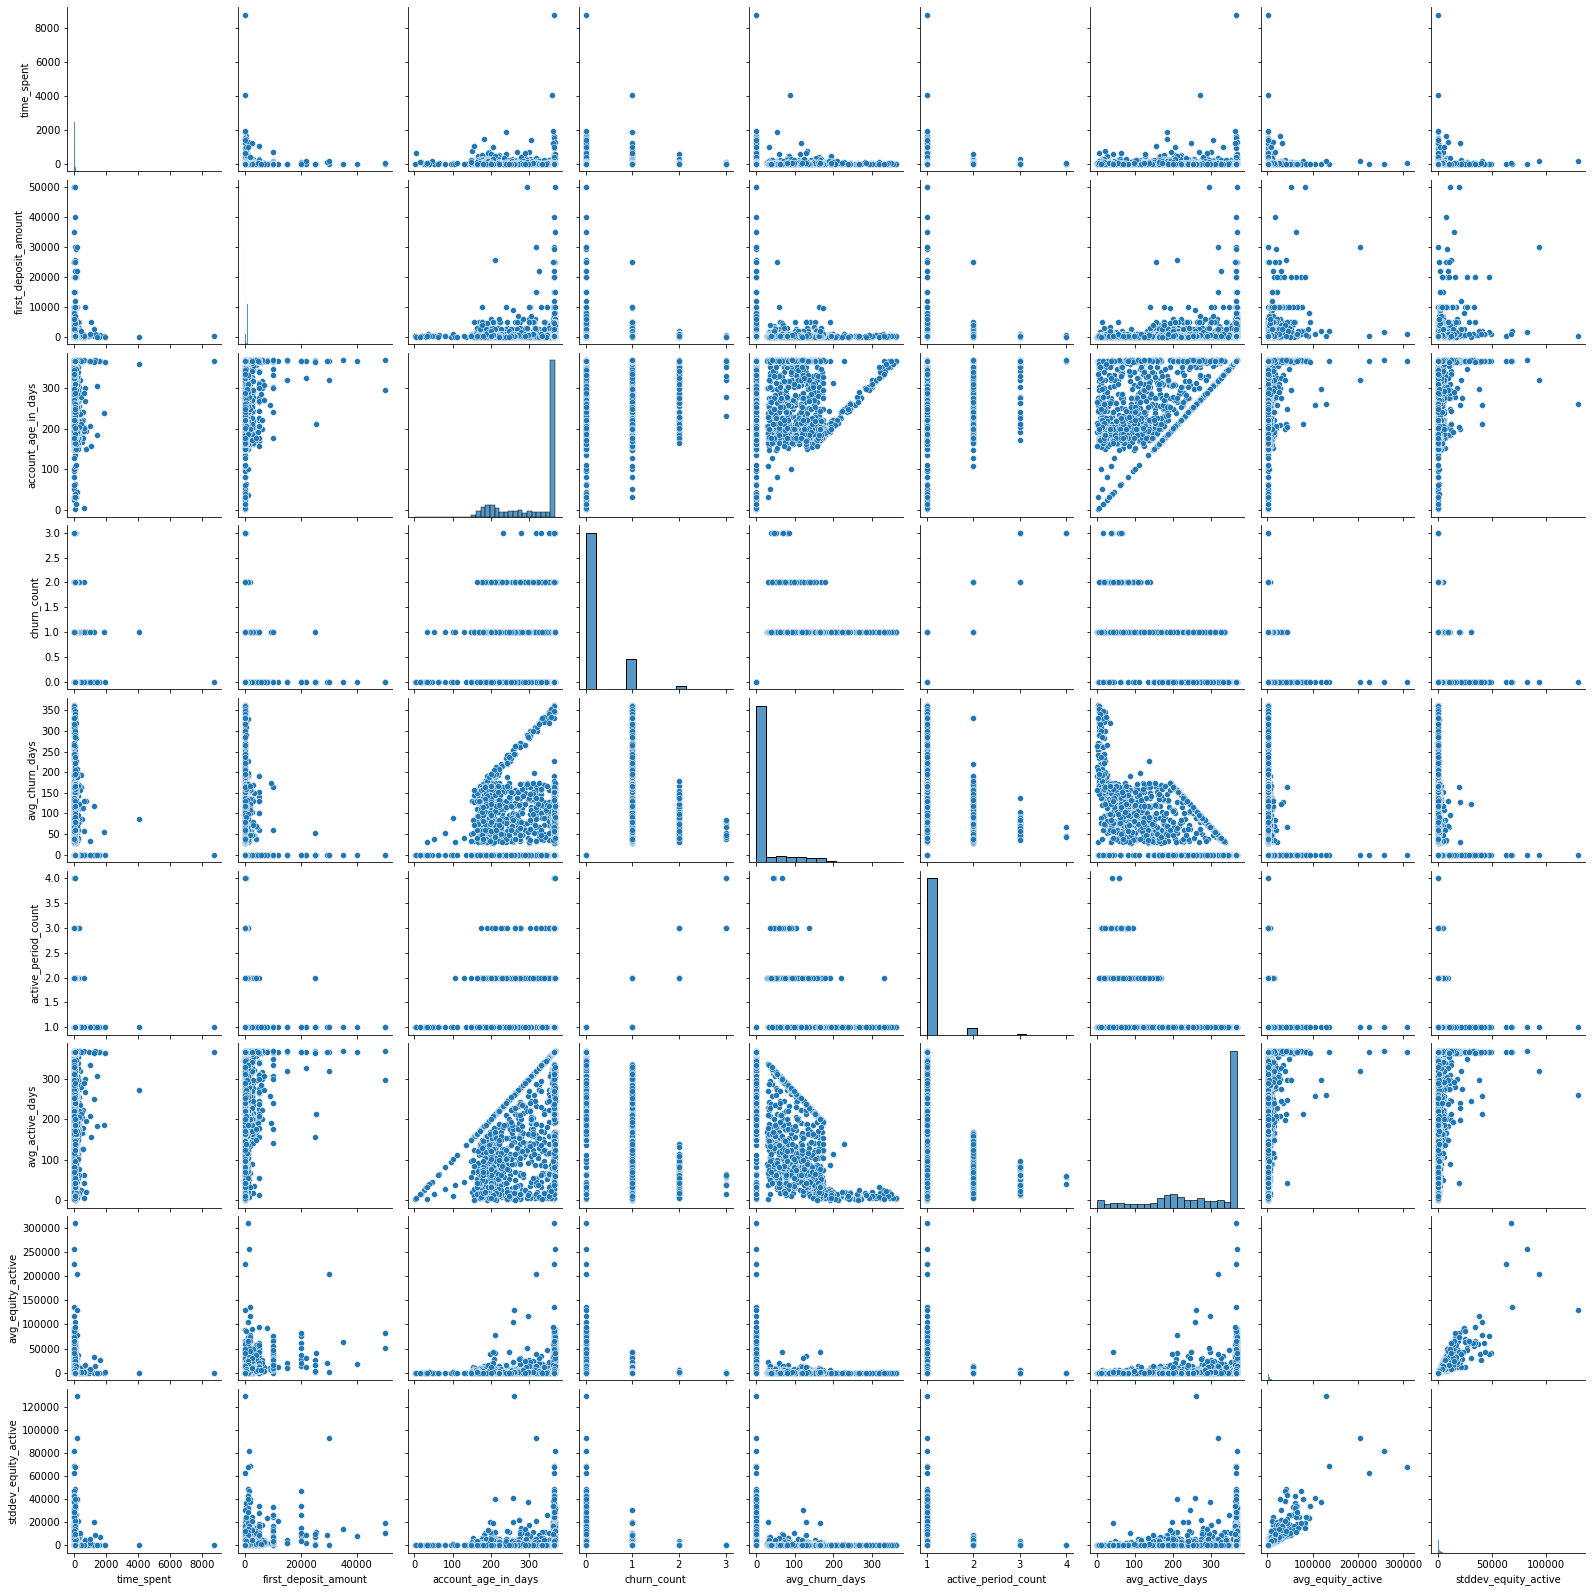

In [170]:
sns.pairplot(final_df)

Since there is high correlation between account_age_in_days and avg_active_days, we drop one of the variables. The same thing is true wrt variables: avg_equity_active and stddev_equity_active, avg_churn_days and churn_count, churn_count and avg_active_days.

In [171]:
final_df.drop(['stddev_equity_active', 
               'account_age_in_days',
               'avg_churn_days',
               'churn_count'],
              axis=1, 
              inplace=True)

In [172]:
final_df[final_df['time_spent'] == 0]

,user_id,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,active_period_count,avg_active_days,avg_equity_active,churn
7,bdc39d2fc664ef9a5e6713168057f892,high_risk_tolerance,good_investment_exp,somewhat_important_liq_need,iOS,0.0,stock,100.0,short_time_horizon,1,166.0,1026.934970,no
8,85f2f0f54411b4f3e7a403ba902e7280,high_risk_tolerance,good_investment_exp,very_important_liq_need,iOS,0.0,stock,5000.0,short_time_horizon,1,368.0,7209.971580,no
16,50cf51b304d3dd9796063cf7b8221ada,high_risk_tolerance,no_investment_exp,very_important_liq_need,iOS,0.0,stock,40.0,short_time_horizon,1,368.0,21.511671,no
18,bb70182208e73de1dccc347d098b4292,high_risk_tolerance,good_investment_exp,very_important_liq_need,iOS,0.0,stock,150.0,short_time_horizon,1,368.0,3171.373476,no
19,44daa41022383125d36277779c8e8f85,low_risk_tolerance,no_investment_exp,very_important_liq_need,both,0.0,stock,50.0,med_time_horizon,1,368.0,26.324103,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5555,86037cc704cedba79b00a71d0c74fcbd,high_risk_tolerance,no_investment_exp,very_important_liq_need,iOS,0.0,stock,20.0,short_time_horizon,1,368.0,43.853266,no
5557,39da635fce1ef178f00c06163c2575b3,med_risk_tolerance,no_investment_exp,very_important_liq_need,iOS,0.0,stock,100.0,long_time_horizon,1,253.0,66.208384,yes
5561,42c4d3fdd3c0024a115e2324cc18090e,high_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,0.0,adr,100.0,long_time_horizon,1,368.0,120.431413,no
5569,51e2fd5633503daa72d6d9b971ead099,high_risk_tolerance,limited_investment_exp,very_important_liq_need,both,0.0,stock,100.0,med_time_horizon,1,367.0,940.656561,no


In [173]:
final_df[final_df['first_deposit_amount'] == 0]

,user_id,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,active_period_count,avg_active_days,avg_equity_active,churn
2474,29e29b170d4844397590e511100e1457,med_risk_tolerance,no_investment_exp,somewhat_important_liq_need,iOS,13.566850,stock,0.0,short_time_horizon,2,82.0,5952.366905,yes
3377,5eb7e5244d0e33ce744fbe2d530b9c75,med_risk_tolerance,no_investment_exp,somewhat_important_liq_need,iOS,36.394150,stock,0.0,med_time_horizon,2,22.0,9.706759,yes
4930,147251e571c44cd4c412bd453329d007,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,63.223983,mlp,0.0,med_time_horizon,1,49.0,9.979592,yes
5373,0e469b74e2911549005bb6160074735a,med_risk_tolerance,good_investment_exp,very_important_liq_need,Android,46.916067,stock,0.0,short_time_horizon,1,169.0,9.974142,yes


In [174]:
corr_matrix = final_df.corr()
corr_matrix

,time_spent,first_deposit_amount,active_period_count,avg_active_days,avg_equity_active
time_spent,1.000000,-0.000770,-0.005503,-0.058459,-0.006346
first_deposit_amount,-0.000770,1.000000,-0.030780,0.090132,0.352219
active_period_count,-0.005503,-0.030780,1.000000,-0.411464,-0.045330
avg_active_days,-0.058459,0.090132,-0.411464,1.000000,0.137760
avg_equity_active,-0.006346,0.352219,-0.045330,0.137760,1.000000


<AxesSubplot:>

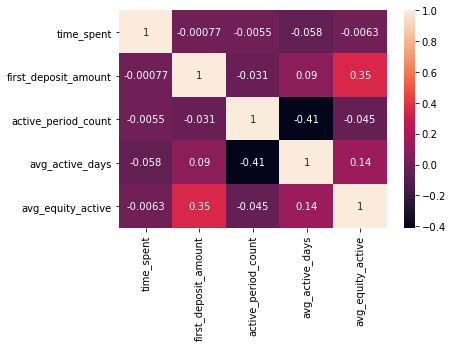

In [175]:
sns.heatmap(corr_matrix, annot=True)

In [176]:
final_df.describe()

,time_spent,first_deposit_amount,active_period_count,avg_active_days,avg_equity_active
count,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000
mean,34.509706,633.566805,1.057307,287.745090,3311.113004
std,155.080551,2118.323263,0.266884,105.652116,10856.975749
min,0.000000,0.000000,1.000000,1.000000,9.377857
25%,2.848908,50.000000,1.000000,211.000000,110.349046
50%,13.474708,100.000000,1.000000,363.000000,520.704632
75%,33.823829,500.000000,1.000000,367.000000,2176.456591
max,8788.329450,50000.000000,4.000000,369.000000,309269.774138


Before doing log transformation for the skewed variables, we need to make sure that there are no zero values in this column because log(0) is undefined.Imputing the records having 0 values as 1.

In [177]:
# Check for 0 values
condition = (final_df['time_spent'] == 0)
final_df['time_spent'] = np.where(condition,
                                  1.0, 
                                  final_df['time_spent'])

In [178]:
# Check for 0 values
condition = (final_df['first_deposit_amount'] == 0)
final_df['first_deposit_amount'] = np.where(condition,
                                            1.0, 
                                            final_df['first_deposit_amount'])

In [179]:
final_df['time_spent_transformed'] = np.log(final_df['time_spent'])
final_df['first_deposit_transformed'] = np.log(final_df['first_deposit_amount'])

In [180]:
final_df.describe()

,time_spent,first_deposit_amount,active_period_count,avg_active_days,avg_equity_active,time_spent_transformed,first_deposit_transformed
count,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000
mean,34.702936,633.567521,1.057307,287.745090,3311.113004,2.341870,4.866465
std,155.038041,2118.323049,0.266884,105.652116,10856.975749,1.605636,1.860953
min,0.092317,0.010000,1.000000,1.000000,9.377857,-2.382531,-4.605170
25%,2.848908,50.000000,1.000000,211.000000,110.349046,1.046936,3.912023
50%,13.474708,100.000000,1.000000,363.000000,520.704632,2.600814,4.605170
75%,33.823829,500.000000,1.000000,367.000000,2176.456591,3.521166,6.214608
max,8788.329450,50000.000000,4.000000,369.000000,309269.774138,9.081180,10.819778


<AxesSubplot:>

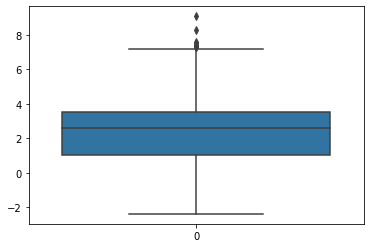

In [181]:
sns.boxplot(data=final_df['time_spent_transformed'])

<AxesSubplot:>

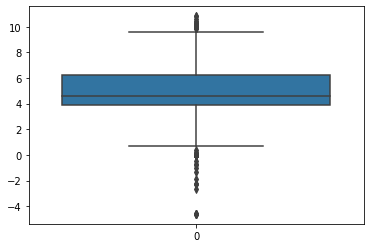

In [182]:
sns.boxplot(data=final_df['first_deposit_transformed'])

In [183]:
final_df['avg_equity_active'].describe()

count      5584.000000
mean       3311.113004
std       10856.975749
min           9.377857
25%         110.349046
50%         520.704632
75%        2176.456591
max      309269.774138
Name: avg_equity_active, dtype: float64

<AxesSubplot:>

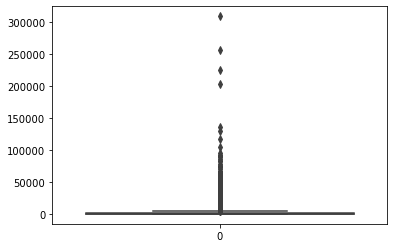

In [184]:
sns.boxplot(data=final_df['avg_equity_active'])

In [185]:
final_df['avg_equity_active_transformed'] = np.log(final_df['avg_equity_active'])

<AxesSubplot:>

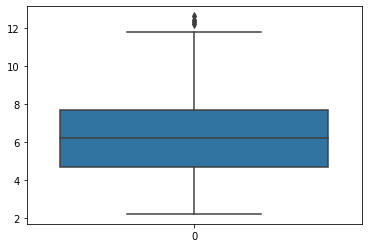

In [186]:
sns.boxplot(data=final_df['avg_equity_active_transformed'])

In [187]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   user_id                        5584 non-null   object 
 1   risk_tolerance                 5584 non-null   object 
 2   investment_experience          5584 non-null   object 
 3   liquidity_needs                5584 non-null   object 
 4   platform                       5584 non-null   object 
 5   time_spent                     5584 non-null   float64
 6   instrument_type_first_traded   5584 non-null   object 
 7   first_deposit_amount           5584 non-null   float64
 8   time_horizon                   5584 non-null   object 
 9   active_period_count            5584 non-null   int64  
 10  avg_active_days                5584 non-null   float64
 11  avg_equity_active              5584 non-null   float64
 12  churn                          5584 non-null   o

In [189]:
final_df['active_period_count'].value_counts()

1    5309
2     233
3      39
4       3
Name: active_period_count, dtype: int64

<AxesSubplot:xlabel='active_period_count', ylabel='count'>

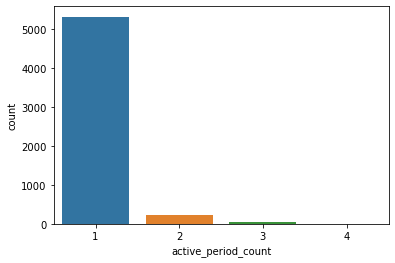

In [190]:
sns.countplot(data=final_df, x='active_period_count')

<AxesSubplot:>

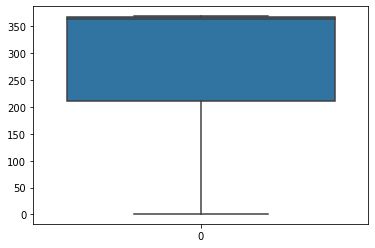

In [191]:
sns.boxplot(data=final_df['avg_active_days'])

In [192]:
final_df.drop(['time_spent', 'first_deposit_amount', \
               'avg_equity_active'], 
              axis=1, 
              inplace=True)

In [193]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   user_id                        5584 non-null   object 
 1   risk_tolerance                 5584 non-null   object 
 2   investment_experience          5584 non-null   object 
 3   liquidity_needs                5584 non-null   object 
 4   platform                       5584 non-null   object 
 5   instrument_type_first_traded   5584 non-null   object 
 6   time_horizon                   5584 non-null   object 
 7   active_period_count            5584 non-null   int64  
 8   avg_active_days                5584 non-null   float64
 9   churn                          5584 non-null   object 
 10  time_spent_transformed         5584 non-null   float64
 11  first_deposit_transformed      5584 non-null   float64
 12  avg_equity_active_transformed  5584 non-null   f

## 2. Data preparation for modelling

For non-ordinal categorical variables with multiple levels, create dummy features (one-hot encoded)

In [194]:
modelling_data = final_df.copy()

In [195]:
dummy = pd.get_dummies(modelling_data[['platform', 'instrument_type_first_traded']], 
                       drop_first=True)
modelling_data = pd.concat([modelling_data, dummy], axis=1)

In [196]:
modelling_data.drop(['platform', 'instrument_type_first_traded'],
                    axis=1,
                    inplace=True)

Map numeric values: 0 or 1 for the binary variable: churn

In [197]:
churn_mapping = {'yes': 1, 'no': 0}
modelling_data['churn'] = modelling_data['churn'].map(churn_mapping)

For ordinal categorical variables, use label encoding

In [198]:
# Apply label encoding to risk_tolerance, investment_experience, liquidity_needs, time_horizon
label_encoder = LabelEncoder()
modelling_data['risk_tolerance'] = \
                    label_encoder.fit_transform(modelling_data['risk_tolerance'])
modelling_data['investment_experience'] = \
                    label_encoder.fit_transform(modelling_data['investment_experience'])
modelling_data['liquidity_needs'] = \
                    label_encoder.fit_transform(modelling_data['liquidity_needs'])
modelling_data['time_horizon'] = \
                    label_encoder.fit_transform(modelling_data['time_horizon'])

In [199]:
modelling_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   user_id                                5584 non-null   object 
 1   risk_tolerance                         5584 non-null   int32  
 2   investment_experience                  5584 non-null   int32  
 3   liquidity_needs                        5584 non-null   int32  
 4   time_horizon                           5584 non-null   int32  
 5   active_period_count                    5584 non-null   int64  
 6   avg_active_days                        5584 non-null   float64
 7   churn                                  5584 non-null   int64  
 8   time_spent_transformed                 5584 non-null   float64
 9   first_deposit_transformed              5584 non-null   float64
 10  avg_equity_active_transformed          5584 non-null   float64
 11  plat

## 3. Model Building And Evaluation

### 3.1 Train and Test split

In [200]:
# Assigning all model feature variables to X
X = modelling_data.drop(['churn','user_id'], axis=1)
X.head()

,risk_tolerance,investment_experience,liquidity_needs,time_horizon,active_period_count,avg_active_days,time_spent_transformed,first_deposit_transformed,avg_equity_active_transformed,platform_both,...,instrument_type_first_traded_adr,instrument_type_first_traded_cef,instrument_type_first_traded_etp,instrument_type_first_traded_lp,instrument_type_first_traded_mlp,instrument_type_first_traded_reit,instrument_type_first_traded_rlt,instrument_type_first_traded_stock,instrument_type_first_traded_tracking,instrument_type_first_traded_wrt
0,0,2,2,1,1,277.0,3.500422,3.688879,4.312080,0,...,0,0,0,0,0,0,0,1,0,0
1,2,2,2,2,1,367.0,2.807806,5.298317,5.825848,0,...,0,0,0,0,0,0,0,1,0,0
2,2,2,2,0,1,367.0,2.303421,3.218876,3.867331,0,...,0,0,0,0,0,0,0,1,0,0
3,2,2,2,2,1,206.0,0.031143,4.605170,5.194204,0,...,0,0,0,0,0,0,0,1,0,0
4,0,2,2,0,1,366.0,2.102578,2.995732,5.301540,0,...,0,0,0,0,0,0,0,1,0,0


In [201]:
# Assigning response variable to y
y = modelling_data['churn']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: churn, dtype: int64

## Question a) What percentage of users have churned in the dataset?

In [206]:
y.value_counts(normalize=True)

0    0.821275
1    0.178725
Name: churn, dtype: float64

### Around 18% of users have churned in the dataset.

In [202]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size=0.8, 
                                                    test_size=0.2, 
                                                    stratify=y,
                                                    random_state=100)

In [203]:
y_train.value_counts()

0    3669
1     798
Name: churn, dtype: int64

In [204]:
y_train.value_counts(normalize=True)

0    0.821357
1    0.178643
Name: churn, dtype: float64

In [205]:
churn_dist = {} 
churn_dist[0] = round(y_train.value_counts(normalize=True)[0], 2)
churn_dist[1] = round(y_train.value_counts(normalize=True)[1], 2)
churn_dist

{0: 0.82, 1: 0.18}

In [207]:
y_test.value_counts()

0    917
1    200
Name: churn, dtype: int64

In [208]:
y_test.value_counts(normalize=True)

0    0.820949
1    0.179051
Name: churn, dtype: float64

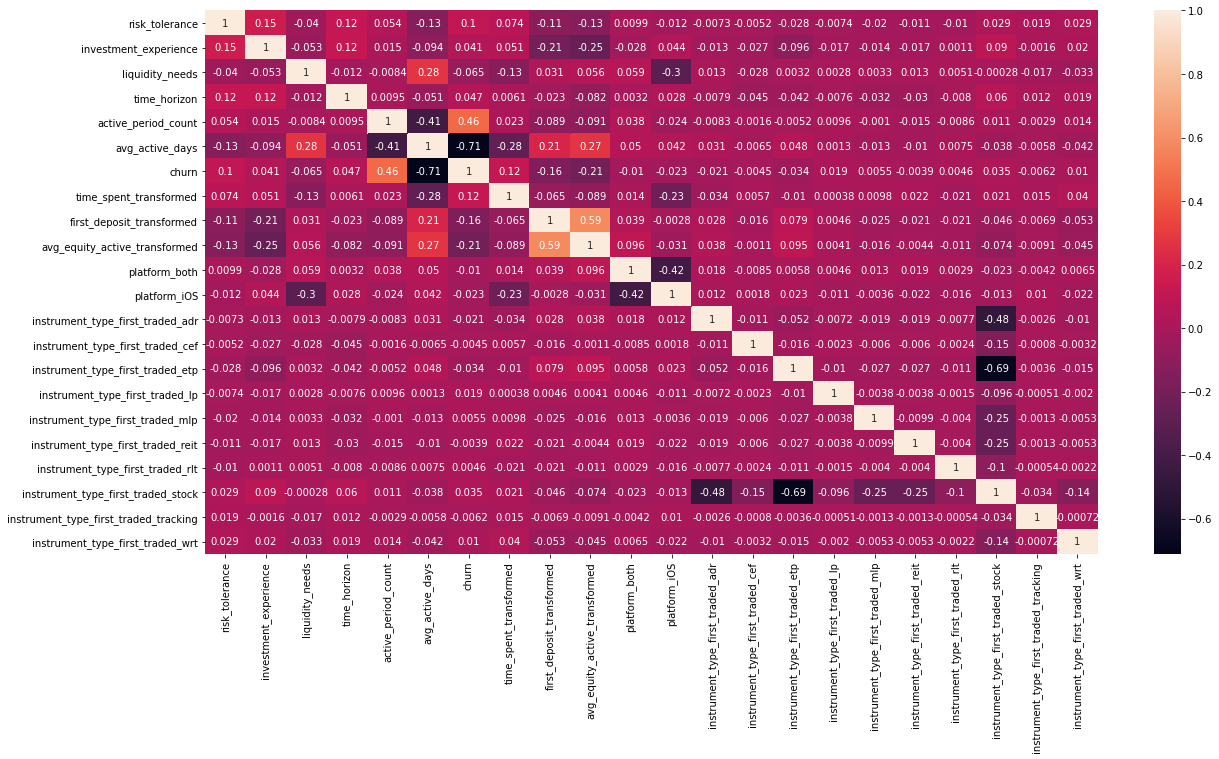

In [209]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(modelling_data.corr(),annot = True)
plt.show()

### 3.2 Feature Scaling

In [211]:
# Create an instance of RobustScaler
scaler = RobustScaler()

In [212]:
X_train[['avg_active_days',
         'time_spent_transformed',
         'first_deposit_transformed',
         'avg_equity_active_transformed']] =\
                                scaler.fit_transform(X_train[['avg_active_days',
                                                              'time_spent_transformed',
                                                              'first_deposit_transformed',
                                                              'avg_equity_active_transformed']])

In [213]:
X_test[['avg_active_days',
        'time_spent_transformed',
        'first_deposit_transformed',
        'avg_equity_active_transformed']] =\
                                scaler.fit_transform(X_test[['avg_active_days',
                                                             'time_spent_transformed',
                                                             'first_deposit_transformed',
                                                             'avg_equity_active_transformed']])

### 3.3 Model Building

In [418]:
class Metrics:
    def __init__(self):
        self.train_metrics = {}
        self.test_metrics = {}

    def update_train_metric(self, name, value):
        self.train_metrics[name] = value

    def update_test_metric(self, name, value):
        self.test_metrics[name] = value

    def get_train_metric(self, name):
        return self.train_metrics.get(name, None)

    def get_test_metric(self, name):
        return self.test_metrics.get(name, None)
   
    def print_train_metrics(self):
        print('*********************************************************')
        print("Train Metrics:")
        print('*********************************************************')
        print()        
        
        self.print_confusion_matrix(self.train_metrics["confusion_matrix"])

        for name, value in self.train_metrics.items():
            if name == "confusion_matrix":
                continue
            metric_name = " ".join(name.split()).upper()
            print(f"{metric_name.upper()}: {value}")

    def print_test_metrics(self):
        print('*********************************************************')        
        print("Test Metrics:")
        print('*********************************************************')
        print()        
        
        self.print_confusion_matrix(self.test_metrics["confusion_matrix"])

        for name, value in self.test_metrics.items():
            if name == "confusion_matrix":
                continue
            metric_name = " ".join(name.split()).upper()
            print(f"{metric_name.upper()}: {value}")

    def print_confusion_matrix(self, cm):
        print(f'                  CONFUSION MATRIX                ')
        pivot_table = pd.DataFrame(cm, 
                                   columns=['Predicted[no churn]', 'Predicted[churn]'],
                                   index=['Actual[no churn]', 'Actual[churn]'])
        print(pivot_table)
        print()
        print()                

In [510]:
class ChurnPredictionModel:
    def __init__(self, model_type='logistic_regression',
                 hyp_param_search_type = "no_tuning",
                 prob_threshold=0.5, **kwargs):
        self.model_type = model_type
        self.model = None
        self.model_args = kwargs
        self.metrics = Metrics()
        self.prob_threshold = prob_threshold
        self.best_model = None
        self.best_params = None
        self.param_grid = None
        self.hyp_param_search_type = hyp_param_search_type
        
    def build_model(self):
        if self.model_type == 'logistic_regression':
            self.model = LogisticRegression(**self.model_args)
            self.param_grid = {        
                'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
                'C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.5, 2],
                'penalty': ['l1', 'l2'],   
                'class_weight': ['balanced', None],
            }
        elif self.model_type == 'decision_tree':
            self.model = DecisionTreeClassifier(**self.model_args)
            # Define the parameter grid of decision tree for hyperparameter tuning
            if self.hyp_param_search_type == "random_search":
                self.param_grid = {
                    'criterion': ['gini', 'entropy'],
                    'max_depth': np.arange(3, 9),
                    'min_samples_split': np.arange(5, 40),
                    'min_samples_leaf': np.arange(10, 30),
                    'max_features': ['auto', 'sqrt', 'log2', None],
                    'class_weight': ['balanced', None],                
                } 
            elif self.hyp_param_search_type == "gridcv_search":
                self.param_grid = {
                    'criterion': ['gini', 'entropy'],
                    'max_depth': [2, 3, 4, 5],
                    'min_samples_split': [5, 7, 9, 10, 11, 13],
                    'min_samples_leaf': [18, 20, 21, 22, 24],
                    'max_features': ['auto', 'sqrt', 'log2', None],
                    'class_weight': ['balanced', 'None'],                
                }                 
        elif self.model_type == 'random_forest':
            self.model = RandomForestClassifier(**self.model_args)
            if self.hyp_param_search_type == "random_search":       
                self.param_grid = {
#                    'n_estimators': [100, 200, 300],
                    'criterion': ['gini', 'entropy'],
                    'max_depth': np.arange(3, 7),
                    'min_samples_split': np.arange(5, 20),
                    'min_samples_leaf': np.arange(10, 25),
                    'max_features': ['auto', 'sqrt', 'log2', None],
                }
        else:
            raise ValueError("Invalid model_type. Supported model types: 'logistic_regression', 'random_forest'")

    def get_hyperparams_using_random_search(self, 
                                            X_train, 
                                            y_train, 
                                            cv=5, 
                                            n_iter=500, 
                                            random_state=100):
        print('Performing random search for obtaining best hyperparams')

#        scoring = {'precision': make_scorer(precision_score),
#                   'recall': make_scorer(recall_score),
#                   'f1-score': make_scorer(f1_score)
#                  }

        scoring = make_scorer(f1_score)
        random_search = RandomizedSearchCV(estimator=self.model, 
                                           param_distributions=self.param_grid,
                                           scoring=scoring,
                                           n_iter=n_iter, 
                                           cv=cv, 
                                           refit="f1-score",
                                           random_state=random_state)
        random_search.fit(X_train, y_train)

        # Save best_model and best params
        #best_model = random_search.best_estimator_
        results = random_search.cv_results_
        best_model = random_search.best_estimator_
        best_params = random_search.best_params_

        return best_model, best_params

    def get_hyperparams_using_gridcv_search(self, 
                                            X_train, 
                                            y_train, 
                                            cv=5, 
                                            random_state=100):

        print('Performing grid search for obtaining best hyperparams')
        
        scoring = make_scorer(f1_score)
#        scoring = {'precision': make_scorer(precision_score),
#                   'recall': make_scorer(recall_score),
#                   'f1-score': make_scorer(f1_score)
#                  }

        # Create GridSearchCV instance
        grid_search = GridSearchCV(estimator=self.model, 
                                   param_grid=self.param_grid, 
                                   scoring=scoring,
                                   cv=cv, 
                                   refit="f1-score")

#        random_search = RandomizedSearchCV(estimator=self.model, 
#                                           param_distributions=self.param_grid,
#                                           scoring=scoring,
#                                           n_iter=n_iter, 
#                                           cv=cv, 
#                                           refit="recall",
#                                           random_state=random_state)
        grid_search.fit(X_train, y_train)

        # Save best_model and best params
        #best_model = random_search.best_estimator_
        results = grid_search.cv_results_
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(best_model)
        print(best_params)
        return best_model, best_params
    
    
    def train_model(self, X_train, y_train):
        print('Training the model')
        if self.hyp_param_search_type == "no_tuning":
            self.train_model_with_no_tuning(X_train, 
                                            y_train)
        elif (self.hyp_param_search_type == "random_search" or \
              self.hyp_param_search_type == "gridcv_search"):
            self.train_model_with_hyperparams_tuning(X_train,
                                                     y_train)
        else:
            print(f'This tuning method: {self.hyp_param_search_type} is not defined!')
            return
        
        #print('Evaluating the model on train data')
        evaluation_metrics = self.evaluate("train",
                                           X_train, 
                                           y_train)
        #print(evaluation_metrics)
        print('Updating train metrics')        
        for key, value in evaluation_metrics.items():
            self.metrics.update_train_metric(key, value)

    def train_model_with_no_tuning(self, X_train, y_train):
        if self.model is None:
            self.build_model()
                      
        print('No hyperparam tuning defined for this model!')
        self.fit(X_train, y_train)
        # Without hyperparameter tuning, best model is same as the model
        # obtained without hyperparameter tuning.
        self.set_best_model(self.model, self.get_model_params())
            
    def train_model_with_hyperparams_tuning(self, X_train, y_train):
        if self.model is None:
            self.build_model()
            
        if self.hyp_param_search_type == "random_search":
            best_model, best_params = self.get_hyperparams_using_random_search(X_train,
                                                                               y_train)
        else:
            best_model, best_params = self.get_hyperparams_using_gridcv_search(X_train,
                                                                               y_train)
        self.set_best_model(best_model, best_params)
                   

    def set_best_model(self, best_model, best_params):
        self.best_model = best_model
        self.best_params = best_params
    
    def get_model_params(self):
        if self.model is None:
            raise ValueError("Model is not yet built. Call 'fit()' to build and fit the model.")

        if self.model_type == 'logistic_regression':
            #print(self.model.coef_[0])
            return {'coef': self.model.coef_[0], 
                    'intercept': self.model.intercept_[0]}
        elif self.model_type == 'decision_tree':
            return self.best_params
        elif self.model_type == 'random_forest':
            return self.best_params
        else:
            raise ValueError("Invalid model_type. Supported model types: 'logistic_regression', 'decision_tree', random_forest'")
        
    def evaluate_model(self, X_test, y_test):
        #print('Evaluating the model on test data')
        if self.best_model is None:
            raise ValueError("Model is not yet trained")

        evaluation_metrics = self.evaluate("test", X_test, y_test)
        print('Updating test metrics')  
        for key, value in evaluation_metrics.items():
            self.metrics.update_test_metric(key, value)

    def print_metrics(self):
        self.metrics.print_train_metrics()
        print()
        self.metrics.print_test_metrics()
        print()
        
    def fit(self, X, y):
        if self.model is None:
            self.build_model()
        self.model.fit(X, y)
    
    def predict(self, X):
        if self.best_model is None:
            raise ValueError("Model is not yet built. Call 'fit()' to build and fit the model.")
        return self.best_model.predict(X)
    
    def predict_proba(self, X):
        if self.best_model is None:
            raise ValueError("Model is not yet built. Call 'fit()' to build and fit the model.")
        return self.best_model.predict_proba(X)
    
    def evaluate(self, data_type, X, y):
        if self.best_model is None:
            raise ValueError("Model is not yet built. Call 'fit()' to build and fit the model.")

        if self.model_type == 'logistic_regression':
            y_prob = self.predict_proba(X)[:, 1]
            y_pred = np.where(y_prob > self.prob_threshold, 1, 0)
        else:
            y_pred = self.predict(X)
        #self.draw_precision_recall_curve(data_type, y, y_prob)
        # Calculate precision, recall, and thresholds
        #precision, recall, thresholds = precision_recall_curve(y, y_prob)
        # Calculate the Area Under the Precision-Recall Curve (AUPRC)
        #auprc = auc(recall, precision)
        # Calculate F1 score for each threshold
        #f1_scores = 2 * (precision * recall) / (precision + recall)

        # Find the index of the threshold that maximizes the F1 score
        #best_threshold_idx = np.argmax(f1_scores)

        # Get the corresponding best threshold
        #best_threshold = thresholds[best_threshold_idx]

        #print(f'Precision: {precision}')
        #print(f'Recall: {recall}')
        #print(f'thresholds: {thresholds}')
        #print(f'Best threshold: {best_threshold}')      
        #y_pred = self.best_model.predict(X)

        cm = confusion_matrix(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        #roc_auc = roc_auc_score(y, y_prob)
        
        evaluation_metrics = {
            'confusion_matrix': cm,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
#            'roc_auc': roc_auc
        }
        return evaluation_metrics

    def draw_precision_recall_curve(self, data_type, y, y_prob):
        # Compute precision and recall values
        precision, recall, thresholds = precision_recall_curve(y, y_prob)

        # Plot the precision-recall curve
        plt.plot(recall, precision, color='b', label='Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for {data_type}')
        plt.legend()
        plt.show()    
        

In [420]:
model_names = []
train_precision = []
train_recall = []
train_f1_score = []
train_false_positives = []
train_false_negatives = []
test_precision = []
test_recall = []
test_f1_score = []
test_false_positives = []
test_false_negatives = []

In [421]:
def update_model_metrics(model_name, model):
    model_names.append(model_name)

    train_precision.append(model.metrics.get_train_metric("precision"))
    train_recall.append(model.metrics.get_train_metric("recall"))
    train_f1_score.append(model.metrics.get_train_metric("f1_score"))
    train_false_positives.append(model.metrics.get_train_metric("confusion_matrix")[0][1])
    train_false_negatives.append(model.metrics.get_train_metric("confusion_matrix")[1][0])
    
    test_precision.append(model.metrics.get_test_metric("precision"))
    test_recall.append(model.metrics.get_test_metric("recall"))
    test_f1_score.append(model.metrics.get_test_metric("f1_score"))
    test_false_positives.append(model.metrics.get_test_metric("confusion_matrix")[0][1])
    test_false_negatives.append(model.metrics.get_test_metric("confusion_matrix")[1][0])


### 3.3.1 Logistic Regression Base Model

Create a simple base model of logistic regression

In [422]:
# Create an instance of ChurnPredictionModel
logistic_model = ChurnPredictionModel(model_type='logistic_regression',
                                        n_jobs=-1,
                                        random_state=100)

# Train model
logistic_model.train_model(X_train,
                             y_train)
# Evaluate model
logistic_model.evaluate_model(X_test,
                                y_test)

logistic_model.print_metrics()

Training the model
No hyperparam tuning defined for this model!
Updating train metrics
Updating test metrics
*********************************************************
Train Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                 3608                61
Actual[churn]                     259               539


PRECISION: 0.8983333333333333
RECALL: 0.6754385964912281
F1_SCORE: 0.771101573676681

*********************************************************
Test Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                  907                10
Actual[churn]                      57               143


PRECISION: 0.934640522875817
RECALL: 0.715
F1_SCORE: 0.8101983002832861



In [423]:
logistic_model.model.coef_

array([[ 0.05098835, -0.23013565,  1.06178424,  0.06911904,  3.17315373,
        -3.42921569, -0.35287576,  0.0132497 , -0.23290562,  0.46854673,
         0.60278788, -0.02018876, -0.23269702, -0.22463056,  0.88568833,
         0.43421918, -0.18731279,  0.91655846, -0.01901899, -0.09314006,
        -0.3749444 ]])

In [424]:
logistic_model.model.intercept_

array([-9.42817776])

In [425]:
update_model_metrics("base", logistic_model)

### 3.3.1 Logistic Regression Base Model with probability threshold

In [426]:
# Create an instance of ChurnPredictionModel
logistic_model_1 = ChurnPredictionModel(model_type='logistic_regression',
                                        prob_threshold=0.3,
                                        n_jobs=-1,
                                        random_state=100)

# Train model
logistic_model_1.train_model(X_train,
                             y_train)
# Evaluate model
logistic_model_1.evaluate_model(X_test,
                                y_test)

logistic_model_1.print_metrics()

Training the model
No hyperparam tuning defined for this model!
Updating train metrics
Updating test metrics
*********************************************************
Train Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                 3423               246
Actual[churn]                     193               605


PRECISION: 0.7109283196239718
RECALL: 0.7581453634085213
F1_SCORE: 0.7337780473013948

*********************************************************
Test Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                  857                60
Actual[churn]                      47               153


PRECISION: 0.7183098591549296
RECALL: 0.765
F1_SCORE: 0.7409200968523003



In [427]:
update_model_metrics("base_with_prob_threshold", logistic_model_1)

### 3.3.2 Logistic Regression Model with class weights defined for imbalanced datasets

In [428]:
# Create an instance of ChurnPredictionModel with class weights defined

# Handle class imbalance with class_weight parameter
logistic_model_2 = ChurnPredictionModel(model_type='logistic_regression',
                                        class_weight='balanced',
                                        n_jobs=-1,
                                        random_state=100)

# Train model
logistic_model_2.train_model(X_train,
                             y_train)
# Evaluate model
logistic_model_2.evaluate_model(X_test,
                                y_test)

logistic_model_2.print_metrics()

Training the model
No hyperparam tuning defined for this model!
Updating train metrics
Updating test metrics
*********************************************************
Train Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                 3188               481
Actual[churn]                     128               670


PRECISION: 0.5821025195482189
RECALL: 0.8395989974937343
F1_SCORE: 0.6875320677270395

*********************************************************
Test Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                  807               110
Actual[churn]                      32               168


PRECISION: 0.60431654676259
RECALL: 0.84
F1_SCORE: 0.702928870292887



This is highly imbalanced dataset. So we used class_weight parameter in Logistic Regression to handle class imbalance. This model(using class weights) penalizes heavily for the misclassifications in the minority class(churned users) during training. Here we see that there is improvement in the recall parameter for test data set while using class_weight param. Therefore, we see increase in the number of true positives(churned users). 


But this also resulted in less focus for the incorrect predictions for true negatives which resulted in decrease in the number of true negatives and also increases false positives. This is due to heavy imbalance in the target class.

In [429]:
feature_coefficients = dict(zip(X_test.columns, logic_reg_model_2.best_model.coef_[0]))
feature_coefficients

{'risk_tolerance': 0.06272663132377215,
 'investment_experience': -0.27743016526681036,
 'liquidity_needs': 1.3566765720148362,
 'time_horizon': 0.07925960379574824,
 'active_period_count': 2.8351727546329806,
 'avg_active_days': -3.585499883607043,
 'time_spent_transformed': -0.2658148050217285,
 'first_deposit_transformed': -0.05801486951410734,
 'avg_equity_active_transformed': -0.2417619490107664,
 'platform_both': 0.5582983849685611,
 'platform_iOS': 0.7896484415811101,
 'instrument_type_first_traded_adr': 0.09069478280350583,
 'instrument_type_first_traded_cef': -0.3651422818193907,
 'instrument_type_first_traded_etp': -0.2172296399459042,
 'instrument_type_first_traded_lp': 1.0093437785009423,
 'instrument_type_first_traded_mlp': 0.9736064010674779,
 'instrument_type_first_traded_reit': -0.155795056801605,
 'instrument_type_first_traded_rlt': 0.9429827336090739,
 'instrument_type_first_traded_stock': 0.07266628223257146,
 'instrument_type_first_traded_tracking': -0.1849375734771

In [430]:
update_model_metrics("class_weights_balanced", logistic_model_2)

### 3.3.3 Logistic Regression Model with SMOTE for oversampling the minority class

In [431]:
# Apply SMOTE only to the training set
smote = SMOTE(random_state=100)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [432]:
y_train_smote.value_counts(normalize=True)

1    0.5
0    0.5
Name: churn, dtype: float64

Now we have balanced dataset with equal observations for positive and negative classes.

In [433]:
# Create logistic regression model
logistic_model_3 = ChurnPredictionModel(model_type='logistic_regression',
                                        n_jobs=-1,
                                        random_state=100)

# Train model on resampled dataset
logistic_model_3.train_model(X_train_smote,
                             y_train_smote)
# Evaluate model
logistic_model_3.evaluate_model(X_test,
                                y_test)

logistic_model_3.print_metrics()

Training the model
No hyperparam tuning defined for this model!
Updating train metrics
Updating test metrics
*********************************************************
Train Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                 3198               471
Actual[churn]                     505              3164


PRECISION: 0.8704264099037139
RECALL: 0.8623603161624421
F1_SCORE: 0.8663745892661555

*********************************************************
Test Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                  817               100
Actual[churn]                      35               165


PRECISION: 0.6226415094339622
RECALL: 0.825
F1_SCORE: 0.7096774193548386



In [434]:
update_model_metrics("smote", logistic_model_3)

This model is overfitting the training data. Model is performing well on training data but not on testing data. So we need to use regularization to prevent overfitting.

### 3.3.4 Logistic Regression Model with SMOTE and regularization applied

In [435]:
# Create an instance of ChurnPredictionModel
logistic_model_4 = ChurnPredictionModel(model_type='logistic_regression',
                                        hyp_param_search_type = "gridcv_search",
                                        n_jobs=-1,
                                        random_state=100)

# Train model on resampled dataset(no class imbalance)
logistic_model_4.train_model(X_train_smote,
                             y_train_smote)
# Evaluate model
logistic_model_4.evaluate_model(X_test,
                                y_test)

logistic_model_4.print_metrics()

Training the model
Performing grid search for obtaining best hyperparams
LogisticRegression(C=2, class_weight='balanced', n_jobs=-1, random_state=100,
                   solver='newton-cg')
{'C': 2, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}
Updating train metrics
Updating test metrics
*********************************************************
Train Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                 3201               468
Actual[churn]                     506              3163


PRECISION: 0.871109887083448
RECALL: 0.8620877623330607
F1_SCORE: 0.8665753424657534

*********************************************************
Test Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no c

In [436]:
logistic_model_4.best_model

LogisticRegression(C=2, class_weight='balanced', n_jobs=-1, random_state=100,
                   solver='newton-cg')

In [437]:
update_model_metrics("smote_and_regularized", logistic_model_4)

### 3.3.4 Logistic Regression Model from previous step with probability threshold changed

In [459]:
# Create an instance of ChurnPredictionModel
logistic_model_5 = ChurnPredictionModel(model_type='logistic_regression',
                                        prob_threshold = 0.7,
                                        C=2,
                                        solver='newton-cg',
                                        n_jobs=-1,
                                        random_state=100)

# Train model on resampled dataset(no class imbalance)
logistic_model_5.train_model(X_train_smote,
                             y_train_smote)
# Evaluate model
logistic_model_5.evaluate_model(X_test,
                                y_test)

logistic_model_5.print_metrics()

Training the model
No hyperparam tuning defined for this model!
Updating train metrics
Updating test metrics
*********************************************************
Train Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                 3459               210
Actual[churn]                     847              2822


PRECISION: 0.9307387862796834
RECALL: 0.7691469065140365
F1_SCORE: 0.8422623489031489

*********************************************************
Test Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                  869                48
Actual[churn]                      47               153


PRECISION: 0.7611940298507462
RECALL: 0.765
F1_SCORE: 0.7630922693266834



In [439]:
update_model_metrics("smote_regularized_and_prob_thres", logistic_model_5)

In [460]:
# Create a dictionary to store the evaluation metrics
logistic_reg_model_summary = {
    'train_precision': train_precision,
    'train_recall': train_recall,
    'train_f1_score': train_f1_score,
    'train_false_positives': train_false_positives,
    'train_false_negatives': train_false_negatives,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1_score': test_f1_score,
    'test_false_positives': test_false_positives,
    'test_false_negatives': test_false_negatives,
}
    
logistic_reg_model_summary_df = pd.DataFrame(data = logistic_reg_model_summary, 
                                             index = model_names)    

In [461]:
logistic_reg_model_summary_df

,train_precision,train_recall,train_f1_score,train_false_positives,train_false_negatives,test_precision,test_recall,test_f1_score,test_false_positives,test_false_negatives
base,0.90,0.68,0.77,61,259,0.93,0.71,0.81,10,57
base_with_prob_threshold,0.71,0.76,0.73,246,193,0.72,0.77,0.74,60,47
class_weights_balanced,0.58,0.84,0.69,481,128,0.60,0.84,0.70,110,32
smote,0.87,0.86,0.87,471,505,0.62,0.82,0.71,100,35
smote_and_regularized,0.87,0.86,0.87,468,506,0.63,0.82,0.71,98,35
smote_regularized_and_prob_thres,0.93,0.77,0.84,210,847,0.76,0.77,0.76,48,47


### Logistic Regression Model Comparison Summary:

Based on the test results, logistic regression base model is having high f1 score but we see recall is low when compared to precision. According to the problem statement, we are interested in finding the churned users. Hence we are interested in high recall and good f1-score to have balance between precision and recall values.

Hence we will be selecting the model: smote_regularized_and_prob_thres which has good recall, precision and f1-scores. Model detects with probility of 0.7

### Predict the probability of the user being churned for the given dataset

In [492]:
y_train_prob = logistic_model_5.predict_proba(X_train)[:, 1]
y_train_prob

array([0.53684707, 0.03761919, 0.01197814, ..., 0.04245204, 0.6425832 ,
       0.60114997])

In [493]:
y_test_prob = logistic_model_5.predict_proba(X_test)[:, 1]
y_test_prob

array([0.62879859, 0.08151276, 0.99323893, ..., 0.06544706, 0.16315015,
       0.04927951])

In [494]:
y_train_pred = np.where(y_train_prob > logistic_model_5.prob_threshold, 1, 0)
y_test_pred = np.where(y_test_prob > logistic_model_5.prob_threshold, 1, 0)

### Predict the whether the user is churned or not for the given dataset

In [495]:
y_train_pred_df = pd.DataFrame({'user_id': modelling_data['user_id'],
                          'predicted_churn_prob': y_train_prob,
                          'predicted_churn': y_train_pred,
                          'actual_churn': y_train.values,
                         },
                         index = y_train.index)
y_train_pred_df.set_index('user_id', inplace = True)


y_test_pred_df = pd.DataFrame({'user_id': modelling_data['user_id'],
                          'predicted_churn_prob': y_test_prob,
                          'predicted_churn': y_test_pred,
                          'actual_churn': y_test.values,
                         },
                         index = y_test.index)
y_test_pred_df.set_index('user_id', inplace = True)

# Define the formatting function
def format_float(x):
    return '{:.2f}'.format(x)

pd.options.display.float_format = format_float

y_pred_df = pd.concat([y_train_pred_df, y_test_pred_df], axis=0)

y_pred_df.head(25)

,predicted_churn_prob,predicted_churn,actual_churn
user_id,,,
e71a4467d0c118e89c341d36fefdb660,0.54,0,1
6794657f1dec6cb48b38b980b75a6be3,0.04,0,0
d2990b619f41de32cc67878401a9a89d,0.01,0,0
c135259a3f36d6ad64ec13d64ce4991d,0.06,0,0
2af3fc2179f50bb8e5f5ef46f67b8483,0.05,0,0
bcfb0417bb5d25ad81ec82438c86b6ab,0.99,1,1
c8d199fb557fac96e10fbf0d3c46f53d,0.07,0,0
306fab71a53dc3d36183ceb92baad9e5,0.43,0,0
ceea767379315e891ee2f77759a3af3b,0.96,1,1


### Churned users for the given dataset predicted by the selected model

In [501]:
churned_users_pred = y_pred_df[y_pred_df['predicted_churn'] == 1]
churned_users_pred

,predicted_churn_prob,predicted_churn,actual_churn
user_id,,,
bcfb0417bb5d25ad81ec82438c86b6ab,0.99,1,1
ceea767379315e891ee2f77759a3af3b,0.96,1,1
fbc5223e0b38db36c9b3439326aae416,1.00,1,1
6db26fd760fe94a152c121f3be3c10e7,1.00,1,1
555b95a8ed430fb303aa0756c343b7e6,0.81,1,1
...,...,...,...
78d1e52ac8d932384e7b3ca53f43a268,0.91,1,1
3346d5bcf7cb9f389a820644812ea8bf,0.74,1,0
279bb51f1642a22e934bb42b0dc25b4c,0.86,1,1


In [502]:
churned_users_actual = y_pred_df[y_pred_df['actual_churn'] == 1]
churned_users_actual

,predicted_churn_prob,predicted_churn,actual_churn
user_id,,,
e71a4467d0c118e89c341d36fefdb660,0.54,0,1
bcfb0417bb5d25ad81ec82438c86b6ab,0.99,1,1
ceea767379315e891ee2f77759a3af3b,0.96,1,1
fbc5223e0b38db36c9b3439326aae416,1.00,1,1
6db26fd760fe94a152c121f3be3c10e7,1.00,1,1
...,...,...,...
04bc2b1bd49990e98a554f5fbdc60aac,0.94,1,1
78d1e52ac8d932384e7b3ca53f43a268,0.91,1,1
279bb51f1642a22e934bb42b0dc25b4c,0.86,1,1


In [503]:
print(f'Number of churned users predicted by the model : {len(list(churned_users_pred.index))}')
print(f'Number of actual churned users : {len(list(churned_users_actual.index))}')

Number of churned users predicted by the model : 1007
Number of actual churned users : 998


In [504]:
print('Predicted churned users')
print('***********************')
print(list(churned_users_pred.index))

Predicted churned users
***********************
['bcfb0417bb5d25ad81ec82438c86b6ab', 'ceea767379315e891ee2f77759a3af3b', 'fbc5223e0b38db36c9b3439326aae416', '6db26fd760fe94a152c121f3be3c10e7', '555b95a8ed430fb303aa0756c343b7e6', '64527d37e21490059f6fd3e4fca4c03a', 'c537562a42bc8e02112f590f500ef7b3', '690f2d2ea68b9a0d4b60b9e70023e59a', '7082ace269763c03e16a2adda1c3d540', 'af9096397395c3879774e5b2c46d6075', '948ceac051af95834026fdb32f896581', 'aac87b2d9bc923d142e136b6626a2e69', 'd1cd41eaf75d8fc3f83c5c29b0b48d3f', '46262d271099f4d7319e5f224a43df2e', '2aa618044c047e33ab6df025541efa98', '4a7a4721e73cfea05be26f3574acd2e2', '70ada64c4dfb1c864e7801809c679854', '8c32a37f842b430aae2915c45a7a2b5e', '561a5ffc194fa93675887d9df4e57289', '5fd68f848dbdfcae6f3db7483d11cf66', '098c34a8a3fa9789a0818f3e8149aa76', 'e49fe6cacde63c7947f3a66ca3466fd7', '88aa014aee1a11189897c975301c34d4', '4937983f2ee7c6001af52b622f03fec8', '3b9f1bdefc6d3c5fb8faa351637e0580', '77e2ac2568295a760470f47fa2932374', 'c0eb9d1466bd8e

### List the most important features that correlates to user churn

In [535]:
coefficients = logistic_model_5.model.coef_[0]
# Get the absolute value of the coefficients
absolute_coefficients = np.abs(coefficients)

In [536]:
# Sort the coefficients in descending order
sorted_indices = np.argsort(absolute_coefficients)[::-1]
sorted_coefficients = absolute_coefficients[sorted_indices]

In [538]:
feature_names = X.columns
feature_names

Index(['risk_tolerance', 'investment_experience', 'liquidity_needs',
       'time_horizon', 'active_period_count', 'avg_active_days',
       'time_spent_transformed', 'first_deposit_transformed',
       'avg_equity_active_transformed', 'platform_both', 'platform_iOS',
       'instrument_type_first_traded_adr', 'instrument_type_first_traded_cef',
       'instrument_type_first_traded_etp', 'instrument_type_first_traded_lp',
       'instrument_type_first_traded_mlp', 'instrument_type_first_traded_reit',
       'instrument_type_first_traded_rlt',
       'instrument_type_first_traded_stock',
       'instrument_type_first_traded_tracking',
       'instrument_type_first_traded_wrt'],
      dtype='object')

In [539]:
top_five_indices = sorted_indices[:5]

print("Top five important features:")
for feature_idx in top_five_indices:
    feature_name = feature_names[feature_idx]
    coefficient = coefficients[feature_idx]
    print(f"{feature_name}: Coefficient = {coefficient}")

Top five important features:
avg_active_days: Coefficient = -3.7713030451062535
active_period_count: Coefficient = 3.367561463783594
instrument_type_first_traded_reit: Coefficient = -3.117286324152762
instrument_type_first_traded_etp: Coefficient = -2.9618089349200907
instrument_type_first_traded_cef: Coefficient = -2.8253512054871157


In [541]:
print("Top five important features:")
print("**********************************")
for feature_idx in top_five_indices:
    feature_name = feature_names[feature_idx]
    print(f"{feature_name}") 

Top five important features:
**********************************
avg_active_days
active_period_count
instrument_type_first_traded_reit
instrument_type_first_traded_etp
instrument_type_first_traded_cef


### 3.3.5 Decision Trees

In [542]:
# Create an instance of DecisionTreeClassifier.
dt_model_1 = ChurnPredictionModel(model_type='decision_tree',
                                  random_state=100)

# Train model
dt_model_1.train_model(X_train,
                       y_train)

# Evaluate model
dt_model_1.evaluate_model(X_test,
                          y_test)

dt_model_1.print_metrics()

Training the model
No hyperparam tuning defined for this model!
Updating train metrics
Updating test metrics
*********************************************************
Train Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                 3669                 0
Actual[churn]                       0               798


PRECISION: 1.0
RECALL: 1.0
F1_SCORE: 1.0

*********************************************************
Test Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                  866                51
Actual[churn]                      44               156


PRECISION: 0.7536231884057971
RECALL: 0.78
F1_SCORE: 0.7665847665847665



From above metrics, its clear that this model is overfitting as we see all the metrics are 100% in the training data but the model doesnt perform well in the unseen test data.

In [543]:
dot_data = tree.export_graphviz(dt_model_1.model, 
                                out_file=None,
                                feature_names=X_train.columns, 
                                #                                class_names=dt_model.classes_,
                                filled=True, 
                                rounded=True, 
                                special_characters=True)
graph = graphviz.Source(dot_data)

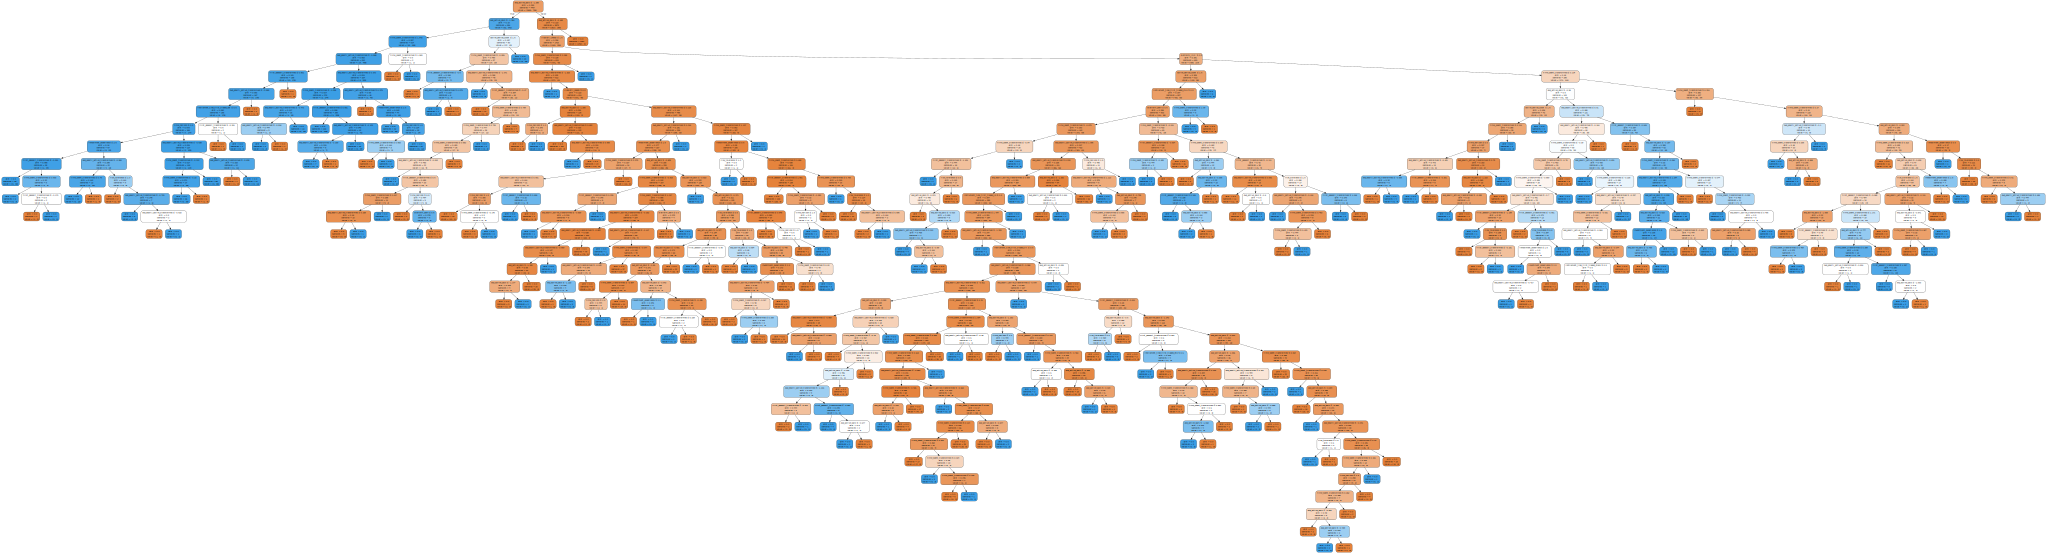

In [544]:
graph

### 3.3.6 Decision Trees with class weight parameter

In [545]:
class_weight_dist = {0: churn_dist[1],
                     1: churn_dist[0]}
print(class_weight_dist)

# Create an instance of DecisionTreeClassifier.
dt_model_2 = ChurnPredictionModel(model_type='decision_tree',
                                  class_weight='balanced',
                                  random_state=100)

# Train model
dt_model_2.train_model(X_train,
                       y_train)

# Evaluate model
dt_model_2.evaluate_model(X_test,
                          y_test)

dt_model_2.print_metrics()

{0: 0.18, 1: 0.82}
Training the model
No hyperparam tuning defined for this model!
Updating train metrics
Updating test metrics
*********************************************************
Train Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                 3669                 0
Actual[churn]                       0               798


PRECISION: 1.0
RECALL: 1.0
F1_SCORE: 1.0

*********************************************************
Test Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                  872                45
Actual[churn]                      44               156


PRECISION: 0.7761194029850746
RECALL: 0.78
F1_SCORE: 0.7780548628428928



This model is also overfitting

### 3.3.7 Decision Trees with hyper parameters

In [550]:
# Create an instance of DecisionTreeClassifier.
dt_model_3 = ChurnPredictionModel(model_type='decision_tree',
                                  class_weight='balanced',
                                  hyp_param_search_type = "random_search",
                                  random_state=100)

# Train model
dt_model_3.train_model(X_train,
                       y_train)

# Evaluate model
dt_model_3.evaluate_model(X_test,
                          y_test)

dt_model_3.print_metrics()

Training the model
Performing random search for obtaining best hyperparams
Updating train metrics
Updating test metrics
*********************************************************
Train Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                 3654                15
Actual[churn]                     276               522


PRECISION: 0.9720670391061452
RECALL: 0.6541353383458647
F1_SCORE: 0.7820224719101124

*********************************************************
Test Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                  915                 2
Actual[churn]                      62               138


PRECISION: 0.9857142857142858
RECALL: 0.69
F1_SCORE: 0.8117647058823529



In [551]:
dt_model_3.best_model

DecisionTreeClassifier(max_depth=4, min_samples_leaf=11, min_samples_split=7,
                       random_state=100)

There is no overfitting. But the recall value is low.

### 3.3.8 Decision Trees with SMOTE data 

In [552]:
# Create an instance of DecisionTreeClassifier.
dt_model_4 = ChurnPredictionModel(model_type='decision_tree',
                                  class_weight='balanced',
                                  hyp_param_search_type = "random_search",
                                  random_state=100)

# Train model
dt_model_4.train_model(X_train_smote,
                       y_train_smote)

# Evaluate model
dt_model_4.evaluate_model(X_test,
                          y_test)

dt_model_4.print_metrics()

Training the model
Performing random search for obtaining best hyperparams
Updating train metrics
Updating test metrics
*********************************************************
Train Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                 3143               526
Actual[churn]                     234              3435


PRECISION: 0.8672052511991921
RECALL: 0.9362224039247752
F1_SCORE: 0.9003931847968546

*********************************************************
Test Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                  795               122
Actual[churn]                      18               182


PRECISION: 0.5986842105263158
RECALL: 0.91
F1_SCORE: 0.7222222222222222



Here we see high recall and low precision

In [553]:
dt_model_4.best_model

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8, min_samples_leaf=18, min_samples_split=30,
                       random_state=100)

In [603]:
update_model_metrics("decision_trees", dt_model_4)

### 3.3.9 Ensembling with random forests

In [569]:

# Create an instance of RandomForest.
rf_model_1 = ChurnPredictionModel(model_type='random_forest',
                                  max_depth=10,
                                  min_samples_leaf=25,
                                  min_samples_split=35,
                                  random_state=100)

# Train model
rf_model_1.train_model(X_train,
                       y_train)

# Evaluate model
rf_model_1.evaluate_model(X_test,
                          y_test)

rf_model_1.print_metrics()

Training the model
No hyperparam tuning defined for this model!
Updating train metrics
Updating test metrics
*********************************************************
Train Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                 3649                20
Actual[churn]                     260               538


PRECISION: 0.96415770609319
RECALL: 0.6741854636591479
F1_SCORE: 0.7935103244837758

*********************************************************
Test Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                  915                 2
Actual[churn]                      56               144


PRECISION: 0.9863013698630136
RECALL: 0.72
F1_SCORE: 0.8323699421965317



We have low recall when compared to high precision.

### 3.3.10 Ensembling with random forests and also using class weights

In [574]:
# Create an instance of RandomForest.
rf_model_2 = ChurnPredictionModel(model_type='random_forest',
                                  class_weight = 'balanced_subsample',
                                  max_depth=10,
                                  min_samples_leaf=25,
                                  min_samples_split=35,
                                  random_state=100)


# Train model
rf_model_2.train_model(X_train,
                       y_train)

# Evaluate model
rf_model_2.evaluate_model(X_test,
                          y_test)

rf_model_2.print_metrics()

Training the model
No hyperparam tuning defined for this model!
Updating train metrics
Updating test metrics
*********************************************************
Train Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                 3274               395
Actual[churn]                      61               737


PRECISION: 0.651060070671378
RECALL: 0.9235588972431078
F1_SCORE: 0.7637305699481864

*********************************************************
Test Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                  830                87
Actual[churn]                      24               176


PRECISION: 0.6692015209125475
RECALL: 0.88
F1_SCORE: 0.7602591792656588



High recall and low precision.

### 3.3.11 Ensembling with random forests and increased estimators and depth

In [597]:
# Create an instance of RandomForest.
rf_model_3 = ChurnPredictionModel(model_type='random_forest',
                                  n_estimators=300,
                                  class_weight = 'balanced_subsample',
                                  max_depth=20,
                                  min_samples_leaf=9,
                                  min_samples_split=10,
                                  random_state=100)


# Train model
rf_model_3.train_model(X_train,
                       y_train)

# Evaluate model
rf_model_3.evaluate_model(X_test,
                          y_test)

rf_model_3.print_metrics()

Training the model
No hyperparam tuning defined for this model!
Updating train metrics
Updating test metrics
*********************************************************
Train Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                 3475               194
Actual[churn]                      46               752


PRECISION: 0.7949260042283298
RECALL: 0.9423558897243107
F1_SCORE: 0.8623853211009174

*********************************************************
Test Metrics:
*********************************************************

                  CONFUSION MATRIX                
                  Predicted[no churn]  Predicted[churn]
Actual[no churn]                  868                49
Actual[churn]                      36               164


PRECISION: 0.7699530516431925
RECALL: 0.82
F1_SCORE: 0.7941888619854722



In [598]:
rf_model_3.best_model

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       min_samples_leaf=9, min_samples_split=10,
                       n_estimators=300, random_state=100)

In [600]:
# Get feature importance
importance = rf_model_3.model.feature_importances_

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

# Sort the DataFrame by importance (descending order)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 5 important features
top_5_features = feature_importance_df.head(5)

# Print the top 5 important features
print(top_5_features)

                         Feature  Importance
5                avg_active_days        0.67
4            active_period_count        0.10
8  avg_equity_active_transformed        0.08
6         time_spent_transformed        0.05
7      first_deposit_transformed        0.03


In [601]:
update_model_metrics("random_forest", rf_model_3)

In [604]:
# Create a dictionary to store the evaluation metrics
model_summary = {
    'train_precision': train_precision,
    'train_recall': train_recall,
    'train_f1_score': train_f1_score,
    'train_false_positives': train_false_positives,
    'train_false_negatives': train_false_negatives,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1_score': test_f1_score,
    'test_false_positives': test_false_positives,
    'test_false_negatives': test_false_negatives,
}
    
model_summary_df = pd.DataFrame(data = model_summary, 
                                index = model_names)    
model_summary_df

,train_precision,train_recall,train_f1_score,train_false_positives,train_false_negatives,test_precision,test_recall,test_f1_score,test_false_positives,test_false_negatives
base,0.90,0.68,0.77,61,259,0.93,0.71,0.81,10,57
base_with_prob_threshold,0.71,0.76,0.73,246,193,0.72,0.77,0.74,60,47
class_weights_balanced,0.58,0.84,0.69,481,128,0.60,0.84,0.70,110,32
smote,0.87,0.86,0.87,471,505,0.62,0.82,0.71,100,35
smote_and_regularized,0.87,0.86,0.87,468,506,0.63,0.82,0.71,98,35
smote_regularized_and_prob_thres,0.93,0.77,0.84,210,847,0.76,0.77,0.76,48,47
random_forest,0.79,0.94,0.86,194,46,0.77,0.82,0.79,49,36
decision_trees,0.87,0.94,0.90,526,234,0.60,0.91,0.72,122,18


### Summary:
With ensembling model(random forest), we found that below are the top 5 important features that are correlated to churn.

We found that random forest performs well wrt to all the measures: precision, recall and f1_score.

1. avg_active_days - average number of active days before the user churns.
2. active_period_count - how many times the user is active in the given time period
3. avg_equity_active_transformed - average equity value during user's active period
4. time_spent_transformed - time spent on the platform
5. first_deposit_transformed - first deposit amount.